This Jupyter notebook contains the GNNExplainer method.

In [45]:
import os

import pandas as pd
import networkx as nx
import numpy as np
import torch

import pickle
import copy

import matplotlib.pyplot as plt

from gensim.models import KeyedVectors


# Set Parameters

In [46]:
dataset_nr = 1
assert dataset_nr == 1 or 2

embedding_method = 'e2v'
assert embedding_method == 'e2v' or 'm2v'

seeded_emb = False

if seeded_emb:
    fixed_emb = '_seeded'
else:
    fixed_emb = ''
    
if dataset_nr == 1 and not seeded_emb:
    threshold_nr_runs = '5'
else:
    threshold_nr_runs = 'all'

# Set Folder

In [47]:
curr_working_dir = os.getcwd()
curr_output_dir = os.path.join(curr_working_dir, 'output')
dataset_output_dir = os.path.join(curr_output_dir, f'g{dataset_nr}_{embedding_method}{fixed_emb}')

if not os.path.exists(dataset_output_dir):
    print('First, run the edge2vec embedding and predictor script. Then, run this script.')
else:
    print(f'Output folder for dataset {dataset_nr} already exists and will be used: {dataset_output_dir}')
    
run_folders_list = []
for item in os.listdir(dataset_output_dir):
    curr_path = os.path.join(dataset_output_dir, item)
    if os.path.isdir(curr_path) and 'run' in item:
        run_folders_list.append(item)
        
expl_output_dir = os.path.join(dataset_output_dir, f'expl_{threshold_nr_runs}')
if not os.path.exists(expl_output_dir):
    os.mkdir(expl_output_dir)
    print(f'Output folder for predictions from dataset {dataset_nr} using method {embedding_method} is created: {expl_output_dir}')
else:
    print(f'Output folder for predictions from dataset {dataset_nr} using method {embedding_method} already exists and will be used: {expl_output_dir}')

run_folders_paths = []
if len(run_folders_list) > 0:
    for run_folder in run_folders_list:
        latest_run = run_folder
        
        run_dir = os.path.join(dataset_output_dir, latest_run)
        run_folders_paths.append(run_dir)
    
else:
    print('First, run the edge2vec embedding and predictor script. Then, run this script.')

Output folder for dataset 1 already exists and will be used: c:\Users\rosa-\Google Drive\Msc_Bioinformatics\thesis\XAIFO-ThesisProject\output\g1_e2v
Output folder for predictions from dataset 1 using method e2v is created: c:\Users\rosa-\Google Drive\Msc_Bioinformatics\thesis\XAIFO-ThesisProject\output\g1_e2v\expl_9


# Load all data

Load the nodes

In [48]:
nodes = pd.read_csv(f'output/indexed_nodes_{dataset_nr}.csv')
nodes

index_id                         id semantic  \
0             0    WormBase:WBGene00000389     ORTH   
1             1                 ZP:0018675     DISO   
2             2  ZFIN:ZDB-GENE-040426-1197     ORTH   
3             3                          5     DRUG   
4             4                   RGD:3443     ORTH   
...         ...                        ...      ...   
10029     10029                 MP:0009763     DISO   
10030     10030                 MP:0011057     DISO   
10031     10031                 MP:0001412     DISO   
10032     10032        WBPhenotype:0004023     DISO   
10033     10033      ClinVarVariant:858516     VARI   

                                                   label  semantic_id  
0                                               cdc-25.4            5  
1      right side lateral plate mesoderm mislocalised...            1  
2                                                 tbc1d5            5  
3                                        (S)-nicardipine            2  
4                                                   Ptk2            5  
...                                                  ...          ...  
10029  increased sensitivity to induced morbidity/mor...            1  
10030                 absent brain ependyma motile cilia            1  
10031                               excessive scratching            1  
10032                     frequency of body bend variant            1  
10033          NM_004006.3(DMD):c.9852G>A (p.Trp3284Ter)            7  

[10034 rows x 5 columns]

In [49]:
nodes.iloc[5487]

index_id            5487
id             HGNC:6717
semantic            GENE
label              LTBP4
semantic_id            3
Name: 5487, dtype: object

In [50]:
node_labels_dict = nodes[['semantic_id', 'semantic']].drop_duplicates().set_index('semantic_id').to_dict()['semantic']
node_labels_dict

{5: 'ORTH',
 1: 'DISO',
 2: 'DRUG',
 4: 'GENO',
 7: 'VARI',
 3: 'GENE',
 0: 'ANAT',
 6: 'PHYS'}

Load the edges

In [51]:
edges = pd.read_csv(f'output/indexed_edges_{dataset_nr}.csv')
edges

head                                   label_head  \
0      ZFIN:ZDB-GENE-050626-112                                         myl4   
1      ZFIN:ZDB-GENE-050626-112                                         myl4   
2      ZFIN:ZDB-GENE-050626-112                                         myl4   
3      ZFIN:ZDB-GENE-050626-112                                         myl4   
4      ZFIN:ZDB-GENE-050626-112                                         myl4   
...                         ...                                          ...   
82939     ClinVarVariant:659584  NC_000023.11:g.(?_32491267)_(32849830_?)del   
82940                      4810                                    ibrutinib   
82941          OMIM:300377.0013                                 DMD, EX18DEL   
82942           Coriell:GM05113                                NIGMS-GM05113   
82943          OMIM:300377.0039                        DMD, 1-BP INS, NT1554   

       class_head  index_head                               relation  \
0               5        5279         in orthology relationship with   
1               5        5279         in orthology relationship with   
2               5        5279         in orthology relationship with   
3               5        5279         in orthology relationship with   
4               5        5279  in 1 to 1 orthology relationship with   
...           ...         ...                                    ...   
82939           7        3184               pathogenic for condition   
82940           2        1618                                targets   
82941           1        2822                           is allele of   
82942           4        8105                   has role in modeling   
82943           1        7364                           is allele of   

                             tail                   label_tail  class_tail  \
0             FlyBase:FBgn0085464                      CG34435           5   
1                       HGNC:7585                         MYL4           3   
2             FlyBase:FBgn0002772                         Mlc1           5   
3                 NCBIGene:396472                         MYL4           3   
4      ENSEMBL:ENSECAG00000020967   ENSEMBL:ENSECAG00000020967           5   
...                           ...                          ...         ...   
82939               MONDO:0010679  Duchenne muscular dystrophy           1   
82940                  HGNC:11283                          SRC           3   
82941                   HGNC:2928                          DMD           3   
82942               MONDO:0010679  Duchenne muscular dystrophy           1   
82943                   HGNC:2928                          DMD           3   

       index_tail  type  
0            6825     0  
1              27     0  
2            8901     0  
3            9508     0  
4            8807     1  
...           ...   ...  
82939        6315    12  
82940        3279    14  
82941        6612    16  
82942        6315    15  
82943        6612    16  

[82944 rows x 10 columns]

In [52]:
def loadEdge2VecEmbedding(current_run_dir): 
    node_feat = KeyedVectors.load(f'{current_run_dir}/w2v_{dataset_nr}.dvectors', mmap='r')
    e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
    for idx, key in enumerate(node_feat.index_to_key):
        e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(node_feat[key])})
        
    return e2v_embedding.sort_values('Node')

def loadMetapath2VecEmbedding(current_run_dir):
    metapath2vec_embedding = pd.read_csv(f'{current_run_dir}/metapath2vec_embedding_{dataset_nr}.csv')
    metapath2vec_embedding['Embedding'] = metapath2vec_embedding.values.tolist()
    metapath2vec_embedding = metapath2vec_embedding[['Embedding']]
    metapath2vec_embedding['Node'] = metapath2vec_embedding.index
    return metapath2vec_embedding[['Node', 'Embedding']]

In [53]:
def create_graph(embedding):
    G = nx.Graph() # TODO: DiGraph?
    for ind, node in embedding.iterrows(): 
        G.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
    for ind, edge in edges.iterrows(): 
        G.add_edge(int(edge['index_head']), int(edge['index_tail']), edge_label = edge['relation'])
    
    for node in G.nodes(data=True):
        print(node)
        break
    for edge in G.edges(data=True):
        print(edge)
        break

    print("Number of edges is {}".format(G.number_of_edges()))
    print("Number of nodes is {}".format(G.number_of_nodes()))
    
    return G

In [54]:
from gnn.linkpred_model import LinkPredModel

def load_trained_model(current_run_dir, embedding):
    with open(f'{current_run_dir}/best_model_{dataset_nr}_{embedding_method}_args.pkl', 'rb') as f:
        loaded_args = pickle.load(f)
        
    best_model = LinkPredModel(len(embedding['Embedding'][0]), 
                            loaded_args['hidden_dim'], loaded_args['output_dim'], 
                            loaded_args['layers'], loaded_args['aggr'], 
                            loaded_args['dropout'], loaded_args['device']).to(loaded_args['device'])
    best_model.load_state_dict(torch.load(f'{run_dir}/best_model_{dataset_nr}_{embedding_method}.pth'))
    
    return best_model

# Explain predictions

In [55]:
from gnn.gnnexplainer import GNNExplainer, visualize_subgraph

num_hops = 1

def explain_edge(node_idx1, node_idx2, model, x, edge_index, G):
    explainer = GNNExplainer(model,
                             epochs=700, num_hops=num_hops, lr=0.01)
    
    trigger = False
    early_stop = 0
    size = 15   # change size of the explanation graph
    iterations = 10 # number of times GNNExplainer is executed
    
    while not trigger:
        _, edge_mask = explainer.explain_link(node_idx1=node_idx1, node_idx2=node_idx2,
                                              x=x, edge_index=edge_index,
                                              G=G)
        
        G2 = copy.deepcopy(G)
        
        if size is not None:
            limit = edge_mask.sort(descending = True)[0][size]
            print('Contribution threshold is', limit)
        else:
            limit = 0.5
        
        for indx, edge in enumerate(G.edges): 
            if edge_mask[indx] < limit:
                G2.remove_edge(edge[0], edge[1])
        
        if nx.has_path(G2, node_idx1, node_idx2) and torch.is_nonzero(limit):
            trigger = True
            
        early_stop += 1
        
        if early_stop == iterations and not trigger:
            print('No good explanation found after {} iterations'.format(early_stop))
            trigger = True
            complete = False
        elif trigger: 
            print('Explanation found!')
            complete = True
            return edge_mask, limit, complete
        
    if torch.is_nonzero(limit):
        return edge_mask, limit, complete
    else:
        return None, None, complete
    

In [56]:
with open(f'{dataset_output_dir}/symptom_drug_pair_overlapping_{threshold_nr_runs}_runs_{dataset_nr}_{embedding_method}{fixed_emb}.pkl', 'rb') as f:
    overlapping_symptom_drug_pairs = pickle.load(f)

overlapping_symptoms_drugs = {}

for overlapping_pair in overlapping_symptom_drug_pairs:
    symptom = overlapping_pair[0]
    drug = overlapping_pair[1]
    
    if symptom in overlapping_symptoms_drugs:
        overlapping_symptoms_drugs[symptom].append(drug)
    else:
        overlapping_symptoms_drugs[symptom] = [drug]
        
overlapping_symptoms_drugs

{'HP:0003115': ['231'],
 'HP:0001270': ['5345'],
 'HP:0011675': ['522', '1576'],
 'HP:0002650': ['5345'],
 'HP:0001638': ['231'],
 'HP:0001256': ['5345'],
 'HP:0001635': ['231'],
 'HP:0003236': ['231'],
 'HP:0001371': ['5345'],
 'HP:0003323': ['231'],
 'HP:0003560': ['231'],
 'HP:0100543': ['5345']}

In [57]:
def get_graph_to_save(G):
    G_save = copy.deepcopy(G)

    for node in G_save.nodes(data=True):
        key = node[1]['y2']
        node[1]['type'] = node_labels_dict[key]
        
    for node in G_save.nodes():
        G_save.nodes[node].pop('y')
        G_save.nodes[node].pop('y2')
        
    for edge in G_save.edges():
        G_save.edges[edge].pop('att')
        G_save.edges[edge].pop('edge_color')

    for node in G_save.nodes(data=True):
        print(node)
    for edge in G_save.edges(data=True):
        print(edge)
        
    return G_save

def visualize_explanation(nr, explanation, edge_index, edge_labels_dict):
    nodes_idxs = torch.Tensor([explanation['node_idx1'], explanation['node_idx2']]).long()
    
    drug_id = explanation['drug']
    drug_name = nodes.loc[nodes['id'] == drug_id]['label'].iloc[0]
    
    symptom_id = explanation['symptom']
    symptom_name = nodes.loc[nodes['id'] == symptom_id]['label'].iloc[0]
    
    run_name = explanation['run']
    
    is_complete = explanation['complete']
    
    explanation_title = f"Explanation for link between {drug_name} ({drug_id}) and {symptom_name} ({symptom_id}) from run {run_name}"

    plt.figure(figsize=(10, 10))
    plt.title(explanation_title)
    ax, G_sub = visualize_subgraph(nodes_idxs, edge_index, explanation['found_edge_mask'], 
                                   nodes=nodes, node_labels_dict=node_labels_dict, y=torch.Tensor(nodes.semantic_id), 
                                   seed=667, num_hops=num_hops, 
                                   threshold=explanation['found_limit'], 
                                   node_label='label', edge_labels=edge_labels_dict, 
                                   show_inactive=False, remove_unconnected=True)
    
    complete_str = ''
    if not is_complete:
        complete_str = 'incomplete_'
    
    plt.savefig(f'{expl_output_dir}/{complete_str}explanation_{nr}_{run_name}.png', bbox_inches='tight')
    plt.show()
    
    # See https://networkx.org/documentation/stable/release/migration_guide_from_2.x_to_3.0.html#deprecated-code
    with open(f'{expl_output_dir}/{complete_str}explanation_{nr}_{run_name}_graph.gpickle', 'wb') as f:
        pickle.dump(get_graph_to_save(G_sub), f, pickle.HIGHEST_PROTOCOL)
        
    print(f'Explanation graph saved at {expl_output_dir}/{complete_str}explanation_{nr}_{run_name}_graph.gpickle')
    
    with open(f'{expl_output_dir}/{complete_str}explanation_{nr}_{run_name}_pair.pkl', 'wb') as f:
        pickle.dump({'drug_id': drug_id, 'drug_name': drug_name, 'symptom_id': symptom_id, 'symptom_name': symptom_name, 'complete': is_complete}, f)
        
    print(f'Explanation pair ids and names saved at {expl_output_dir}/{complete_str}explanation_{nr}_{run_name}_pair.pkl')

c:\Users\rosa-\Google Drive\Msc_Bioinformatics\thesis\XAIFO-ThesisProject\output\g1_e2v\run_001


(0, {'node_feature': tensor([-0.1209, -0.2902, -0.4958, -0.1553, -0.0668, -0.9376, -0.8031,  0.0820,
        -0.6614, -0.1969,  0.4639,  0.3368, -0.0860, -0.0694,  0.4194, -0.1025,
        -0.8487,  0.6225, -0.1325,  0.5251,  0.2266,  0.5813, -0.2551, -1.1433,
        -0.5723, -0.1078, -0.3522,  0.1775, -0.0989,  0.6263,  0.1083,  0.2808])})
(0, 5765, {'edge_label': 'interacts with'})
Number of edges is 52053
Number of nodes is 10034
node1:
      index_id          id semantic       label  semantic_id
9512      9512  HP:0011675     DISO  Arrhythmia            1
node2:
     index_id    id semantic         label  semantic_id
517       517  1576     DRUG  levosimendan            2
Prediction from trained model: tensor([0.5806], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 516.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 504.47it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 452.20it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 479.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 465.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 473.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 457.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 465.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6297], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 360.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 464.55it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


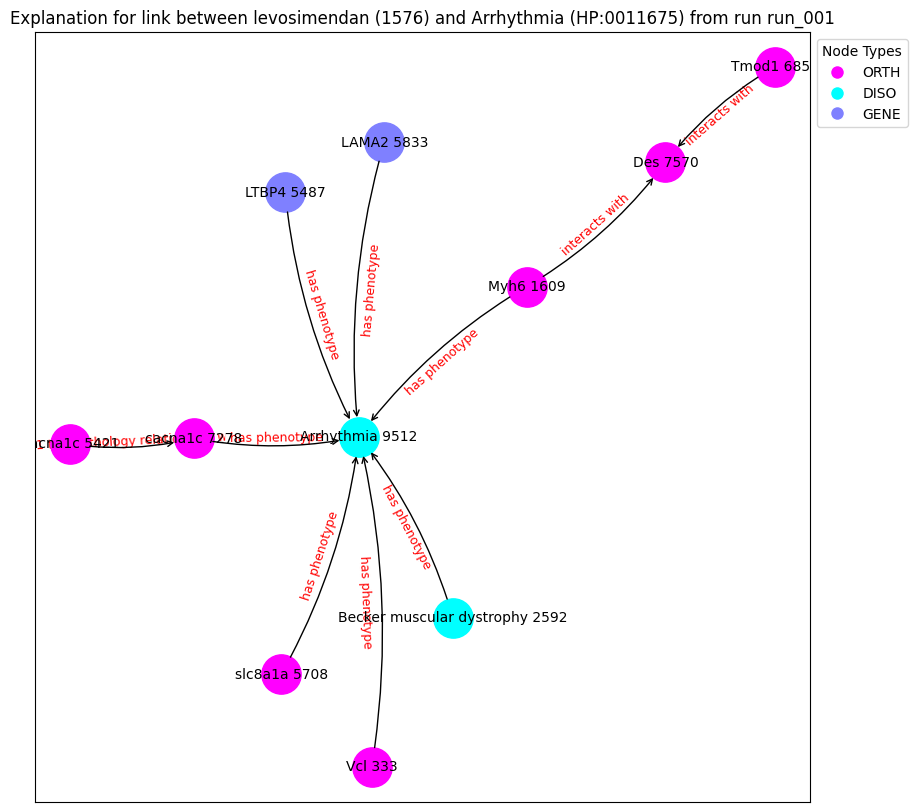

('Vcl 333', {'type': 'ORTH'})
('Myh6 1609', {'type': 'ORTH'})
('Becker muscular dystrophy 2592', {'type': 'DISO'})
('Cacna1c 5421', {'type': 'ORTH'})
('LTBP4 5487', {'type': 'GENE'})
('slc8a1a 5708', {'type': 'ORTH'})
('LAMA2 5833', {'type': 'GENE'})
('Tmod1 6852', {'type': 'ORTH'})
('cacna1c 7278', {'type': 'ORTH'})
('Des 7570', {'type': 'ORTH'})
('Arrhythmia 9512', {'type': 'DISO'})
('Vcl 333', 'Arrhythmia 9512', {'label': 'has phenotype'})
('Myh6 1609', 'Des 7570', {'label': 'interacts with'})
('Myh6 1609', 'Arrhythmia 9512', {'label': 'has phenotype'})
('Becker muscular dystrophy 2592', 'Arrhythmia 9512', {'label': 'has phenotype'})
('Cacna1c 5421', 'cacna1c 7278', {'label': 'in 1 to 1 orthology relationship with'})
('LTBP4 5487', 'Arrhythmia 9512', {'label': 'has phenotype'})
('slc8a1a 5708', 'Arrhythmia 9512', {'label': 'has phenotype'})
('LAMA2 5833', 'Arrhythmia 9512', {'label': 'has phenotype'})
('Tmod1 6852', 'Des 7570', {'label': 'interacts with'})
('cacna1c 7278', 'Arrhythm

Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 418.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6194], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 462.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5742], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 415.39it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 493.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 477.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 406.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6121], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 486.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 488.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 473.23it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 526.76it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


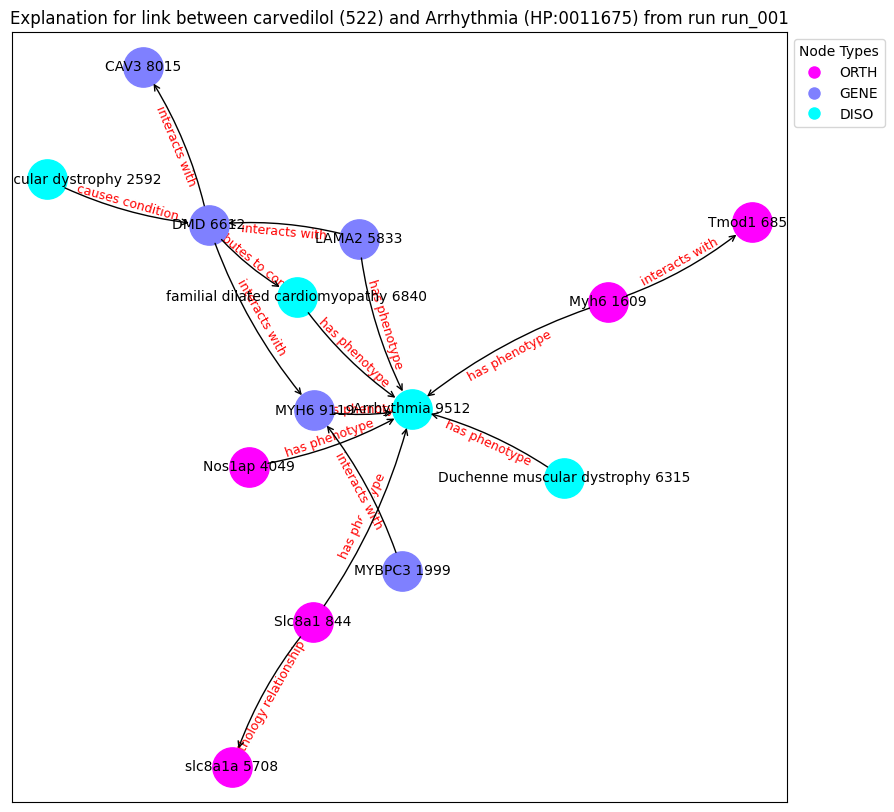

('Slc8a1 844', {'type': 'ORTH'})
('Myh6 1609', {'type': 'ORTH'})
('MYBPC3 1999', {'type': 'GENE'})
('Becker muscular dystrophy 2592', {'type': 'DISO'})
('Nos1ap 4049', {'type': 'ORTH'})
('slc8a1a 5708', {'type': 'ORTH'})
('LAMA2 5833', {'type': 'GENE'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('DMD 6612', {'type': 'GENE'})
('familial dilated cardiomyopathy 6840', {'type': 'DISO'})
('Tmod1 6852', {'type': 'ORTH'})
('CAV3 8015', {'type': 'GENE'})
('MYH6 9119', {'type': 'GENE'})
('Arrhythmia 9512', {'type': 'DISO'})
('Slc8a1 844', 'slc8a1a 5708', {'label': 'in orthology relationship with'})
('Slc8a1 844', 'Arrhythmia 9512', {'label': 'has phenotype'})
('Myh6 1609', 'Tmod1 6852', {'label': 'interacts with'})
('Myh6 1609', 'Arrhythmia 9512', {'label': 'has phenotype'})
('MYBPC3 1999', 'MYH6 9119', {'label': 'interacts with'})
('Becker muscular dystrophy 2592', 'DMD 6612', {'label': 'causes condition'})
('Nos1ap 4049', 'Arrhythmia 9512', {'label': 'has phenotype'})
('LAMA2 583

Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 548.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5856], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 539.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 475.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5933], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 445.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 510.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 502.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 541.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6293], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 583.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 499.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5798], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 493.55it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic                          label  \
4247      4247  HP:0001256     DISO  Intellectual disability, mild   

      semantic_id  
4247            1  
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.7643], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 505.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 555.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 611.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 626.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 629.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 644.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8847], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 583.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8537], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 378.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8336], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 583.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 634.45it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic               label  semantic_id
2788      2788  HP:0003560     DISO  Muscular dystrophy            1
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.5347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 482.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 494.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 481.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 381.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 468.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 373.81it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 407.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 519.34it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 474.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6023], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 466.80it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


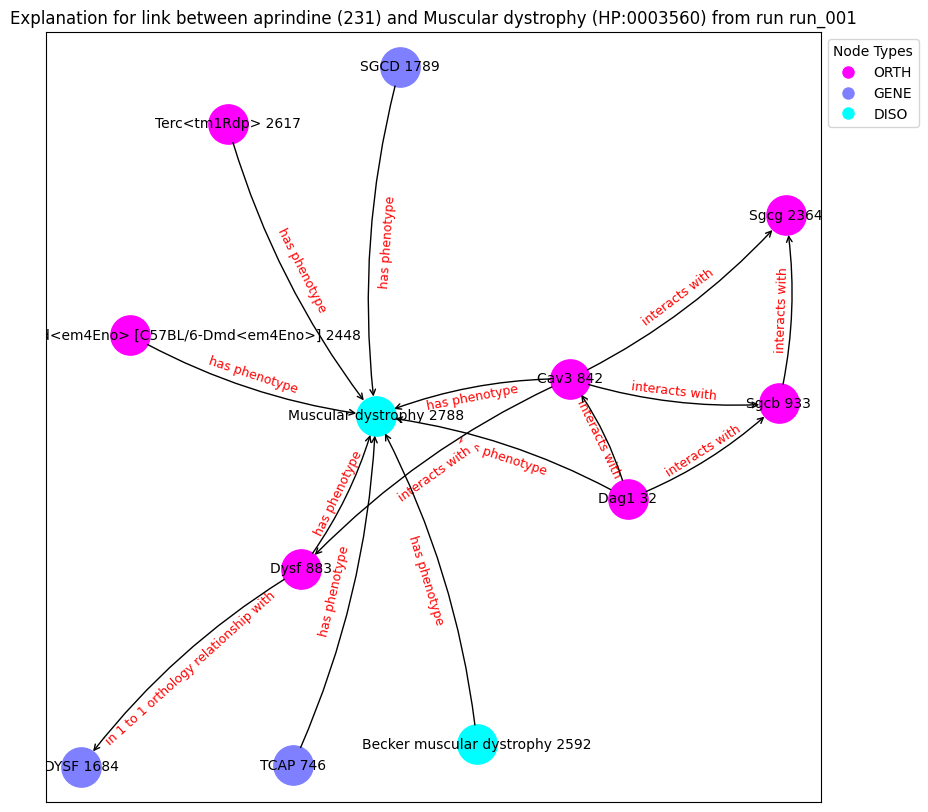

('Dag1 32', {'type': 'ORTH'})
('TCAP 746', {'type': 'GENE'})
('Cav3 842', {'type': 'ORTH'})
('Dysf 883', {'type': 'ORTH'})
('Sgcb 933', {'type': 'ORTH'})
('DYSF 1684', {'type': 'GENE'})
('SGCD 1789', {'type': 'GENE'})
('Sgcg 2364', {'type': 'ORTH'})
('Dmd<em4Eno>/Dmd<em4Eno> [C57BL/6-Dmd<em4Eno>] 2448', {'type': 'ORTH'})
('Becker muscular dystrophy 2592', {'type': 'DISO'})
('Terc<tm1Rdp> 2617', {'type': 'ORTH'})
('Muscular dystrophy 2788', {'type': 'DISO'})
('Dag1 32', 'Muscular dystrophy 2788', {'label': 'has phenotype'})
('Dag1 32', 'Cav3 842', {'label': 'interacts with'})
('Dag1 32', 'Sgcb 933', {'label': 'interacts with'})
('TCAP 746', 'Muscular dystrophy 2788', {'label': 'has phenotype'})
('Cav3 842', 'Sgcg 2364', {'label': 'interacts with'})
('Cav3 842', 'Muscular dystrophy 2788', {'label': 'has phenotype'})
('Cav3 842', 'Sgcb 933', {'label': 'interacts with'})
('Cav3 842', 'Dysf 883', {'label': 'interacts with'})
('Dysf 883', 'DYSF 1684', {'label': 'in 1 to 1 orthology relations

Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 396.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5737], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 384.18it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 413.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:02<00:00, 349.72it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 421.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 441.53it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.4676], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 392.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 423.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 427.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 467.55it/s]


Contribution threshold is tensor(0.9939)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


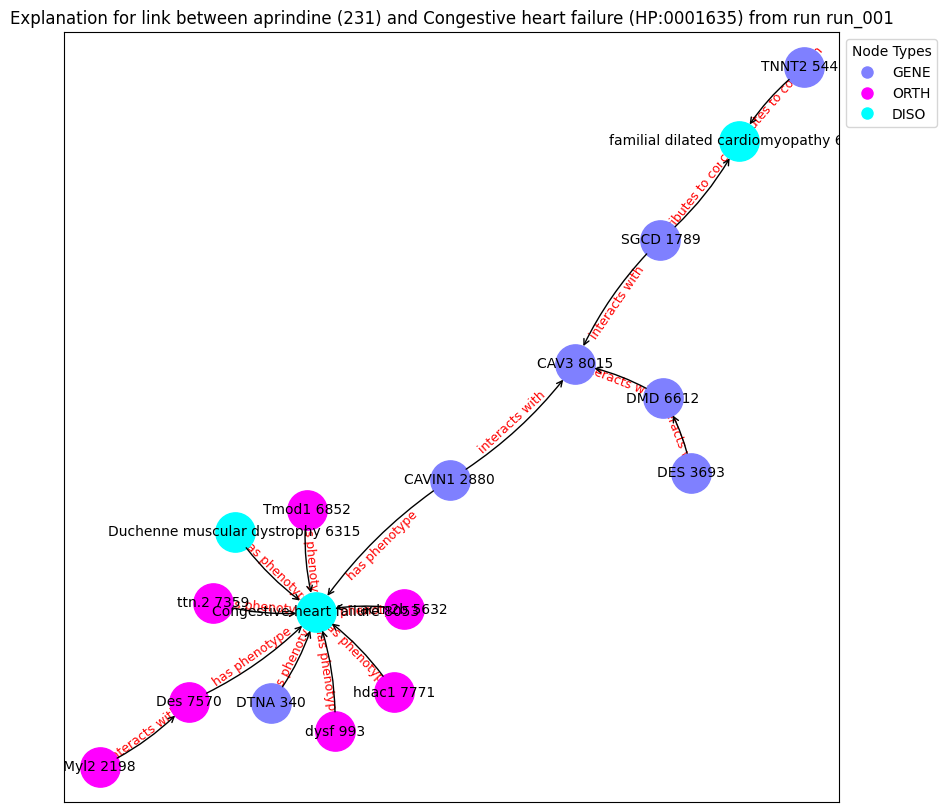

('DTNA 340', {'type': 'GENE'})
('dysf 993', {'type': 'ORTH'})
('SGCD 1789', {'type': 'GENE'})
('Myl2 2198', {'type': 'ORTH'})
('CAVIN1 2880', {'type': 'GENE'})
('DES 3693', {'type': 'GENE'})
('TNNT2 5448', {'type': 'GENE'})
('actn2b 5632', {'type': 'ORTH'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('DMD 6612', {'type': 'GENE'})
('familial dilated cardiomyopathy 6840', {'type': 'DISO'})
('Tmod1 6852', {'type': 'ORTH'})
('ttn.2 7359', {'type': 'ORTH'})
('Des 7570', {'type': 'ORTH'})
('hdac1 7771', {'type': 'ORTH'})
('CAV3 8015', {'type': 'GENE'})
('Congestive heart failure 8053', {'type': 'DISO'})
('DTNA 340', 'Congestive heart failure 8053', {'label': 'has phenotype'})
('dysf 993', 'Congestive heart failure 8053', {'label': 'has phenotype'})
('SGCD 1789', 'CAV3 8015', {'label': 'interacts with'})
('SGCD 1789', 'familial dilated cardiomyopathy 6840', {'label': 'contributes to condition'})
('Myl2 2198', 'Des 7570', {'label': 'interacts with'})
('CAVIN1 2880', 'CAV3 8015', {'

Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 491.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 666.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 630.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 613.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 667.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4488], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 600.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6421], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 573.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 469.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 593.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 496.27it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic                label  semantic_id
4563      4563  HP:0001371     DISO  Flexion contracture            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.8161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 478.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 428.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 536.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 471.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7640], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 495.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 514.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7712], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 380.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 503.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 552.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 584.79it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic      label  semantic_id
4273      4273  HP:0002650     DISO  Scoliosis            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.8794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 530.64it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9257], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 529.91it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8640], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 410.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 548.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 478.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 484.61it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9248], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 540.51it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8437], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 513.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 399.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 470.96it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


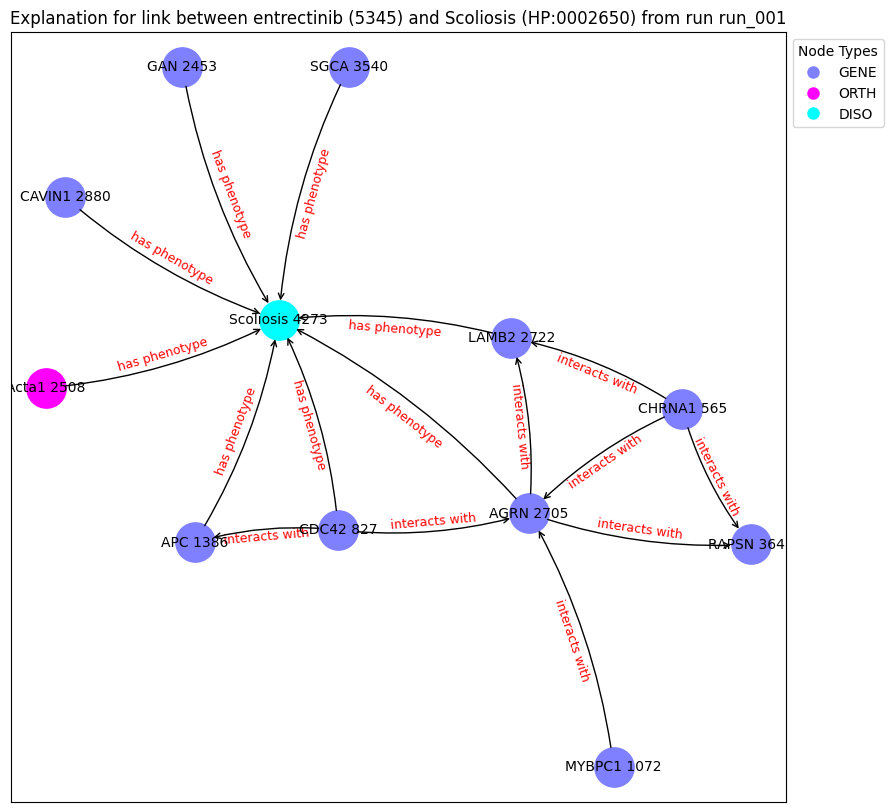

('CHRNA1 565', {'type': 'GENE'})
('CDC42 827', {'type': 'GENE'})
('MYBPC1 1072', {'type': 'GENE'})
('APC 1386', {'type': 'GENE'})
('GAN 2453', {'type': 'GENE'})
('Acta1 2508', {'type': 'ORTH'})
('AGRN 2705', {'type': 'GENE'})
('LAMB2 2722', {'type': 'GENE'})
('CAVIN1 2880', {'type': 'GENE'})
('SGCA 3540', {'type': 'GENE'})
('RAPSN 3648', {'type': 'GENE'})
('Scoliosis 4273', {'type': 'DISO'})
('CHRNA1 565', 'LAMB2 2722', {'label': 'interacts with'})
('CHRNA1 565', 'AGRN 2705', {'label': 'interacts with'})
('CHRNA1 565', 'RAPSN 3648', {'label': 'interacts with'})
('CDC42 827', 'APC 1386', {'label': 'interacts with'})
('CDC42 827', 'Scoliosis 4273', {'label': 'has phenotype'})
('CDC42 827', 'AGRN 2705', {'label': 'interacts with'})
('MYBPC1 1072', 'AGRN 2705', {'label': 'interacts with'})
('APC 1386', 'Scoliosis 4273', {'label': 'has phenotype'})
('GAN 2453', 'Scoliosis 4273', {'label': 'has phenotype'})
('Acta1 2508', 'Scoliosis 4273', {'label': 'has phenotype'})
('AGRN 2705', 'LAMB2 272

Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 563.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 455.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 426.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 544.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 598.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6190], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 560.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 612.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6281], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 539.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5420], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 564.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 606.24it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic           label  semantic_id
1379      1379  HP:0001638     DISO  Cardiomyopathy            1
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.6804], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 604.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 583.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5173], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 605.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5927], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 605.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 578.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 581.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 576.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 608.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5646], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 601.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 606.68it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic        label  semantic_id
1333      1333  HP:0001270     DISO  Motor delay            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.7176], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 638.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 644.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 563.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 599.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 580.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 587.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 544.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5974], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 521.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 458.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 549.11it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic                 label  semantic_id
9833      9833  HP:0100543     DISO  Cognitive impairment            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.8387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 504.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8047], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 479.17it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 539.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7616], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 493.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7175], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 503.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 499.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 523.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 491.62it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8080], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 452.20it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8577], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 515.28it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


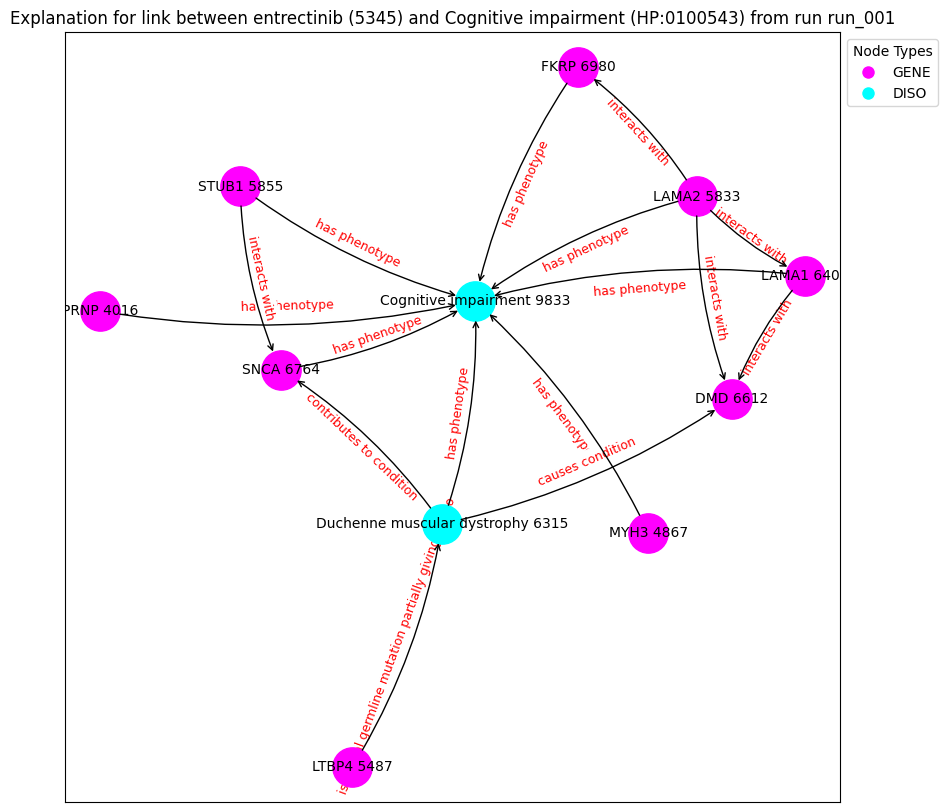

('PRNP 4016', {'type': 'GENE'})
('MYH3 4867', {'type': 'GENE'})
('LTBP4 5487', {'type': 'GENE'})
('LAMA2 5833', {'type': 'GENE'})
('STUB1 5855', {'type': 'GENE'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('LAMA1 6406', {'type': 'GENE'})
('DMD 6612', {'type': 'GENE'})
('SNCA 6764', {'type': 'GENE'})
('FKRP 6980', {'type': 'GENE'})
('Cognitive impairment 9833', {'type': 'DISO'})
('PRNP 4016', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('MYH3 4867', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('LTBP4 5487', 'Duchenne muscular dystrophy 6315', {'label': 'is causal germline mutation partially giving rise to'})
('LAMA2 5833', 'DMD 6612', {'label': 'interacts with'})
('LAMA2 5833', 'FKRP 6980', {'label': 'interacts with'})
('LAMA2 5833', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('LAMA2 5833', 'LAMA1 6406', {'label': 'interacts with'})
('STUB1 5855', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('STUB1 5855', 'SNCA 6764', {'l

Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 443.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 464.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6584], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 430.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 488.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6413], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 438.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5676], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 475.39it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6014], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 402.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 435.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 479.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 499.21it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


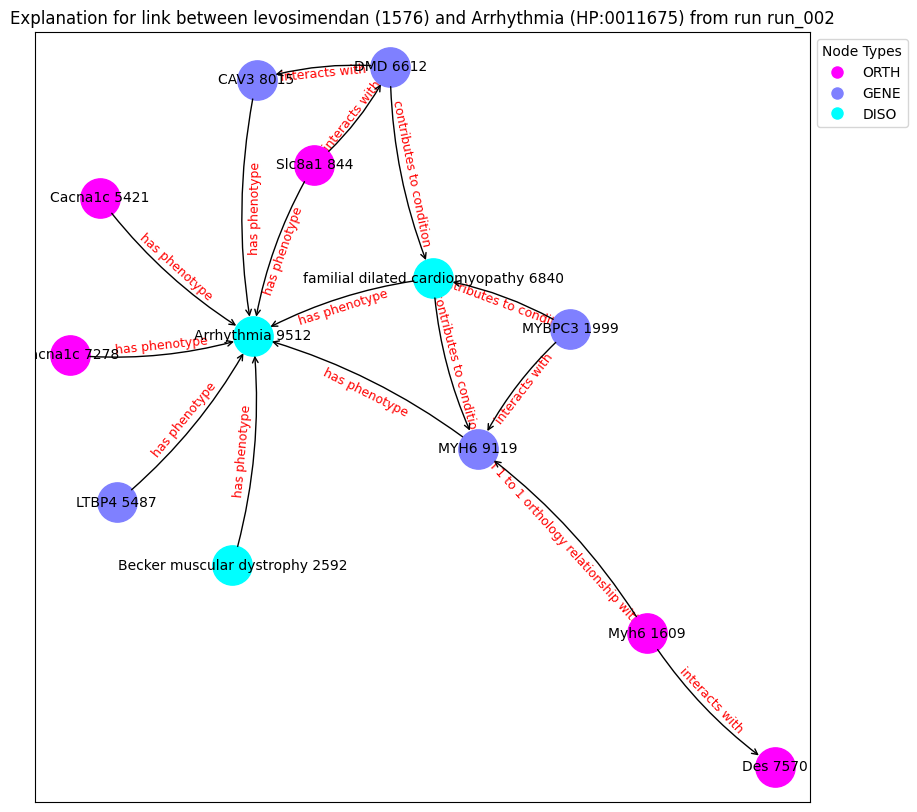

('Slc8a1 844', {'type': 'ORTH'})
('Myh6 1609', {'type': 'ORTH'})
('MYBPC3 1999', {'type': 'GENE'})
('Becker muscular dystrophy 2592', {'type': 'DISO'})
('Cacna1c 5421', {'type': 'ORTH'})
('LTBP4 5487', {'type': 'GENE'})
('DMD 6612', {'type': 'GENE'})
('familial dilated cardiomyopathy 6840', {'type': 'DISO'})
('cacna1c 7278', {'type': 'ORTH'})
('Des 7570', {'type': 'ORTH'})
('CAV3 8015', {'type': 'GENE'})
('MYH6 9119', {'type': 'GENE'})
('Arrhythmia 9512', {'type': 'DISO'})
('Slc8a1 844', 'DMD 6612', {'label': 'interacts with'})
('Slc8a1 844', 'Arrhythmia 9512', {'label': 'has phenotype'})
('Myh6 1609', 'MYH6 9119', {'label': 'in 1 to 1 orthology relationship with'})
('Myh6 1609', 'Des 7570', {'label': 'interacts with'})
('MYBPC3 1999', 'MYH6 9119', {'label': 'interacts with'})
('MYBPC3 1999', 'familial dilated cardiomyopathy 6840', {'label': 'contributes to condition'})
('Becker muscular dystrophy 2592', 'Arrhythmia 9512', {'label': 'has phenotype'})
('Cacna1c 5421', 'Arrhythmia 9512',

Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 435.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 488.57it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 444.44it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 397.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 526.25it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 495.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4680], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 414.71it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 519.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 486.55it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 484.23it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


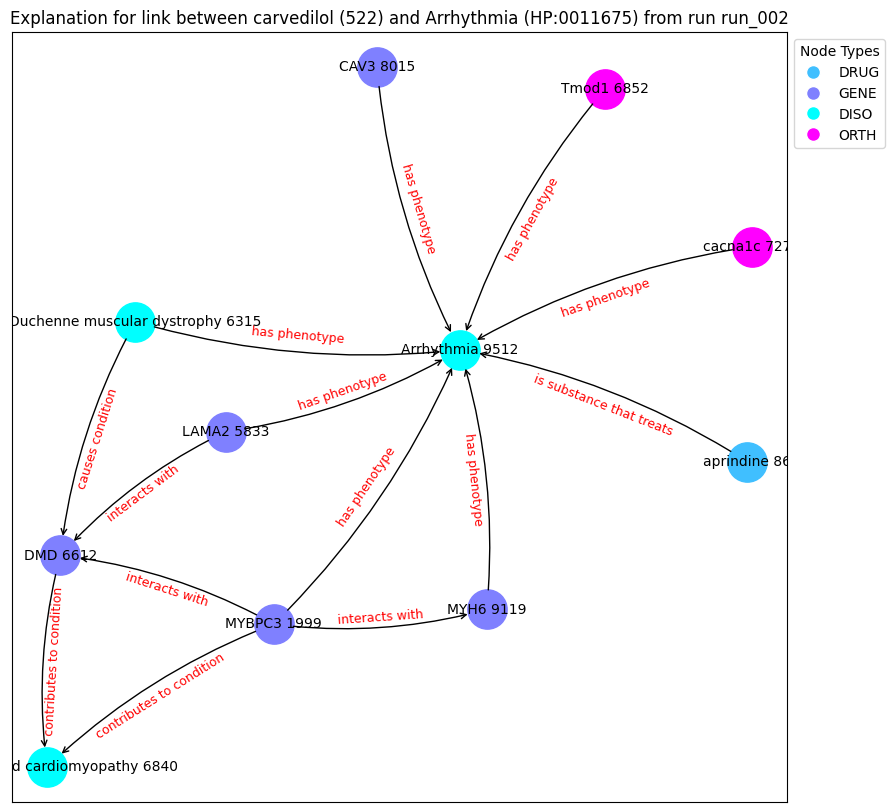

('aprindine 86', {'type': 'DRUG'})
('MYBPC3 1999', {'type': 'GENE'})
('LAMA2 5833', {'type': 'GENE'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('DMD 6612', {'type': 'GENE'})
('familial dilated cardiomyopathy 6840', {'type': 'DISO'})
('Tmod1 6852', {'type': 'ORTH'})
('cacna1c 7278', {'type': 'ORTH'})
('CAV3 8015', {'type': 'GENE'})
('MYH6 9119', {'type': 'GENE'})
('Arrhythmia 9512', {'type': 'DISO'})
('aprindine 86', 'Arrhythmia 9512', {'label': 'is substance that treats'})
('MYBPC3 1999', 'MYH6 9119', {'label': 'interacts with'})
('MYBPC3 1999', 'DMD 6612', {'label': 'interacts with'})
('MYBPC3 1999', 'Arrhythmia 9512', {'label': 'has phenotype'})
('MYBPC3 1999', 'familial dilated cardiomyopathy 6840', {'label': 'contributes to condition'})
('LAMA2 5833', 'DMD 6612', {'label': 'interacts with'})
('LAMA2 5833', 'Arrhythmia 9512', {'label': 'has phenotype'})
('Duchenne muscular dystrophy 6315', 'DMD 6612', {'label': 'causes condition'})
('Duchenne muscular dystrophy 6315', 

Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 584.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7221], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 533.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 516.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 551.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 645.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 591.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6206], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 615.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7614], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 637.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7304], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 600.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 625.28it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic               label  semantic_id
2788      2788  HP:0003560     DISO  Muscular dystrophy            1
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.6966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 511.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 486.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 528.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 511.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 529.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6644], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 531.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4431], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 542.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5640], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 402.42it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 467.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6220], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 463.96it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


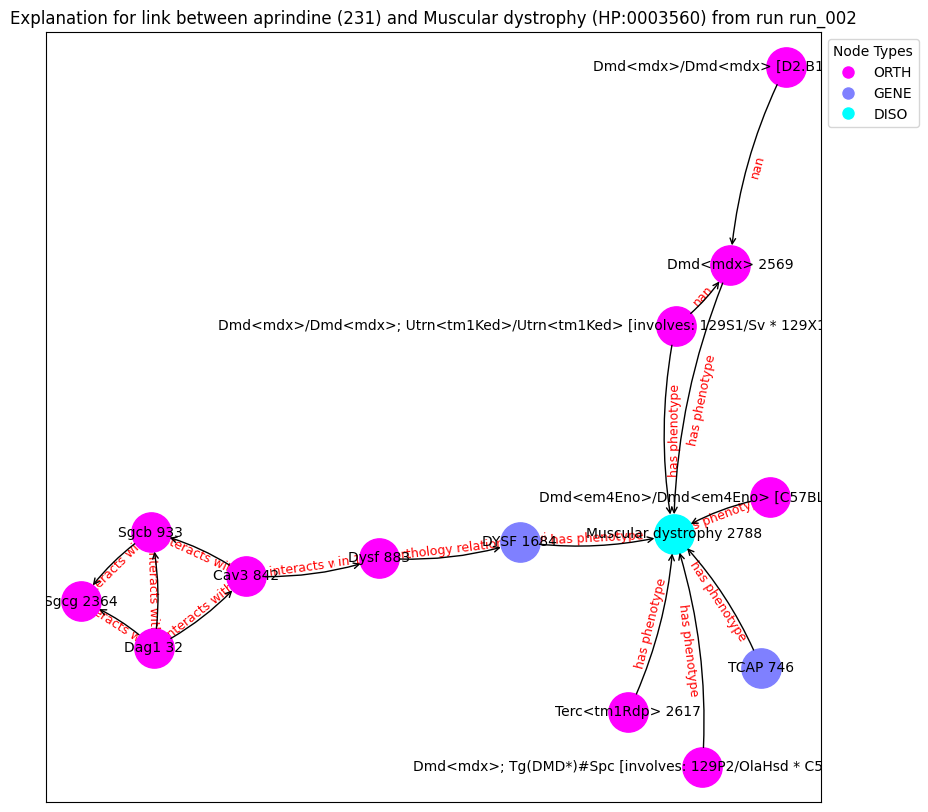

('Dmd<mdx>; Tg(DMD*)#Spc [involves: 129P2/OlaHsd * C57BL/10ScSn * DBA/2] 20', {'type': 'ORTH'})
('Dag1 32', {'type': 'ORTH'})
('TCAP 746', {'type': 'GENE'})
('Cav3 842', {'type': 'ORTH'})
('Dysf 883', {'type': 'ORTH'})
('Sgcb 933', {'type': 'ORTH'})
('Dmd<mdx>/Dmd<mdx> [D2.B10-Dmd<mdx>/J] 1530', {'type': 'ORTH'})
('DYSF 1684', {'type': 'GENE'})
('Sgcg 2364', {'type': 'ORTH'})
('Dmd<em4Eno>/Dmd<em4Eno> [C57BL/6-Dmd<em4Eno>] 2448', {'type': 'ORTH'})
('Dmd<mdx>/Dmd<mdx>; Utrn<tm1Ked>/Utrn<tm1Ked> [involves: 129S1/Sv * 129X1/SvJ * C57BL/6 * C57BL/10ScSn * DBA] 2477', {'type': 'ORTH'})
('Dmd<mdx> 2569', {'type': 'ORTH'})
('Terc<tm1Rdp> 2617', {'type': 'ORTH'})
('Muscular dystrophy 2788', {'type': 'DISO'})
('Dmd<mdx>; Tg(DMD*)#Spc [involves: 129P2/OlaHsd * C57BL/10ScSn * DBA/2] 20', 'Muscular dystrophy 2788', {'label': 'has phenotype'})
('Dag1 32', 'Cav3 842', {'label': 'interacts with'})
('Dag1 32', 'Sgcb 933', {'label': 'interacts with'})
('Dag1 32', 'Sgcg 2364', {'label': 'interacts with'

Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 424.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5881], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 387.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6072], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:02<00:00, 335.30it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 423.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 462.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6363], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 420.26it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5849], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 462.69it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 410.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 381.39it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 411.36it/s]


Contribution threshold is tensor(0.9939)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


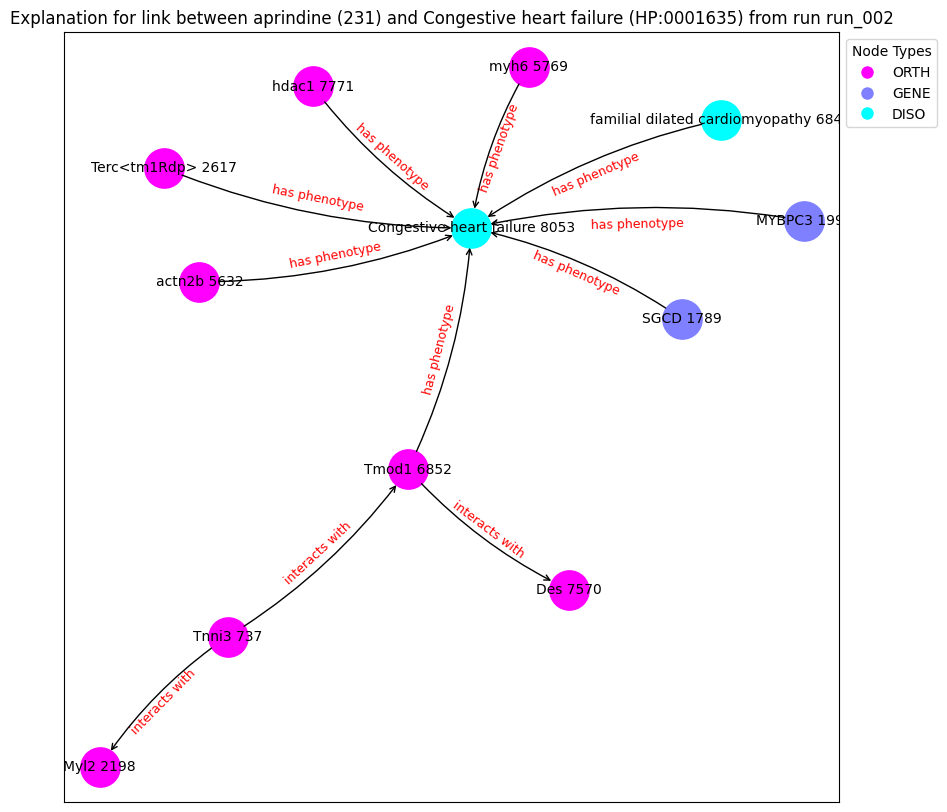

('Tnni3 737', {'type': 'ORTH'})
('SGCD 1789', {'type': 'GENE'})
('MYBPC3 1999', {'type': 'GENE'})
('Myl2 2198', {'type': 'ORTH'})
('Terc<tm1Rdp> 2617', {'type': 'ORTH'})
('actn2b 5632', {'type': 'ORTH'})
('myh6 5769', {'type': 'ORTH'})
('familial dilated cardiomyopathy 6840', {'type': 'DISO'})
('Tmod1 6852', {'type': 'ORTH'})
('Des 7570', {'type': 'ORTH'})
('hdac1 7771', {'type': 'ORTH'})
('Congestive heart failure 8053', {'type': 'DISO'})
('Tnni3 737', 'Tmod1 6852', {'label': 'interacts with'})
('Tnni3 737', 'Myl2 2198', {'label': 'interacts with'})
('SGCD 1789', 'Congestive heart failure 8053', {'label': 'has phenotype'})
('MYBPC3 1999', 'Congestive heart failure 8053', {'label': 'has phenotype'})
('Terc<tm1Rdp> 2617', 'Congestive heart failure 8053', {'label': 'has phenotype'})
('actn2b 5632', 'Congestive heart failure 8053', {'label': 'has phenotype'})
('myh6 5769', 'Congestive heart failure 8053', {'label': 'has phenotype'})
('familial dilated cardiomyopathy 6840', 'Congestive hea

Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 626.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 635.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 633.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 535.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 412.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7379], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 571.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 441.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 607.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 601.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 581.02it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic                label  semantic_id
4563      4563  HP:0001371     DISO  Flexion contracture            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.4692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 575.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4185], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 554.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 549.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4739], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 530.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 557.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4291], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 517.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 477.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 552.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 589.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5255], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 562.47it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic      label  semantic_id
4273      4273  HP:0002650     DISO  Scoliosis            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.5299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 509.31it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 476.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 417.08it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5779], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 540.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5251], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 553.75it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 487.76it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 400.37it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4255], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 512.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 511.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 457.00it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


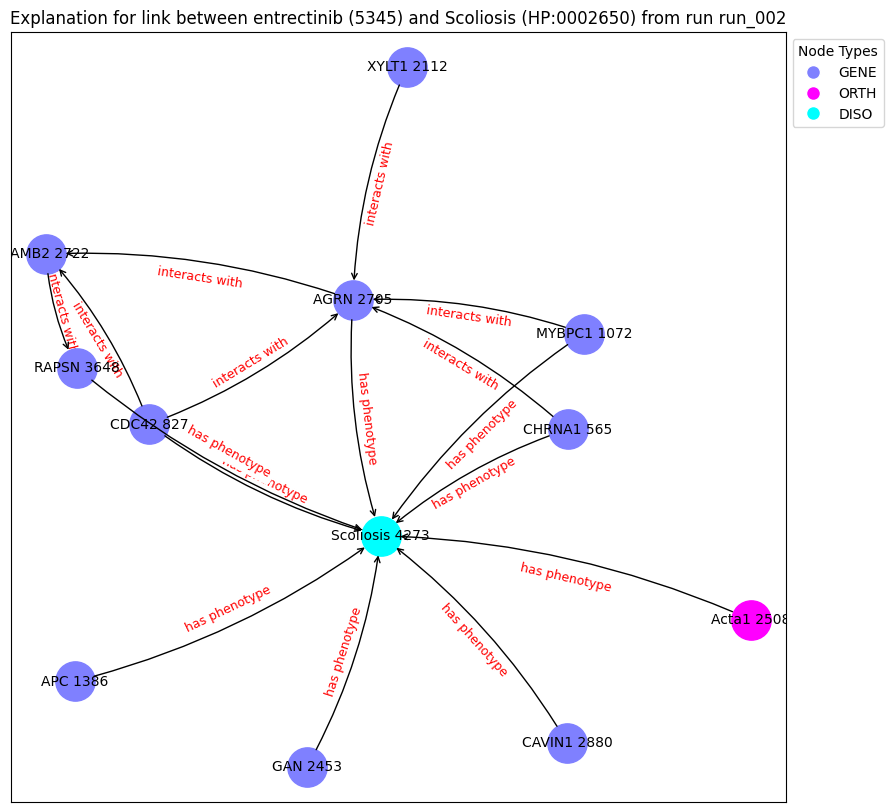

('CHRNA1 565', {'type': 'GENE'})
('CDC42 827', {'type': 'GENE'})
('MYBPC1 1072', {'type': 'GENE'})
('APC 1386', {'type': 'GENE'})
('XYLT1 2112', {'type': 'GENE'})
('GAN 2453', {'type': 'GENE'})
('Acta1 2508', {'type': 'ORTH'})
('AGRN 2705', {'type': 'GENE'})
('LAMB2 2722', {'type': 'GENE'})
('CAVIN1 2880', {'type': 'GENE'})
('RAPSN 3648', {'type': 'GENE'})
('Scoliosis 4273', {'type': 'DISO'})
('CHRNA1 565', 'Scoliosis 4273', {'label': 'has phenotype'})
('CHRNA1 565', 'AGRN 2705', {'label': 'interacts with'})
('CDC42 827', 'LAMB2 2722', {'label': 'interacts with'})
('CDC42 827', 'Scoliosis 4273', {'label': 'has phenotype'})
('CDC42 827', 'AGRN 2705', {'label': 'interacts with'})
('MYBPC1 1072', 'AGRN 2705', {'label': 'interacts with'})
('MYBPC1 1072', 'Scoliosis 4273', {'label': 'has phenotype'})
('APC 1386', 'Scoliosis 4273', {'label': 'has phenotype'})
('XYLT1 2112', 'AGRN 2705', {'label': 'interacts with'})
('GAN 2453', 'Scoliosis 4273', {'label': 'has phenotype'})
('Acta1 2508', 'Sc

Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 555.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 516.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 461.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 551.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6140], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 538.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6349], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 528.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5164], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 571.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 532.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6036], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 472.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5397], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 394.80it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic           label  semantic_id
1379      1379  HP:0001638     DISO  Cardiomyopathy            1
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.5276], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 557.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5604], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 545.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7594], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 604.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 582.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5806], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 585.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 600.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6420], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 610.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7849], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 604.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6372], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 501.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 591.03it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic        label  semantic_id
1333      1333  HP:0001270     DISO  Motor delay            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.4851], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 616.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 513.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5753], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 558.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 528.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 551.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 533.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5479], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 563.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 579.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5758], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 518.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 618.60it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic                 label  semantic_id
9833      9833  HP:0100543     DISO  Cognitive impairment            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.5346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 530.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5349], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 540.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 504.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 488.69it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 472.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 533.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3633], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 527.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 551.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 484.19it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4545], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 502.12it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


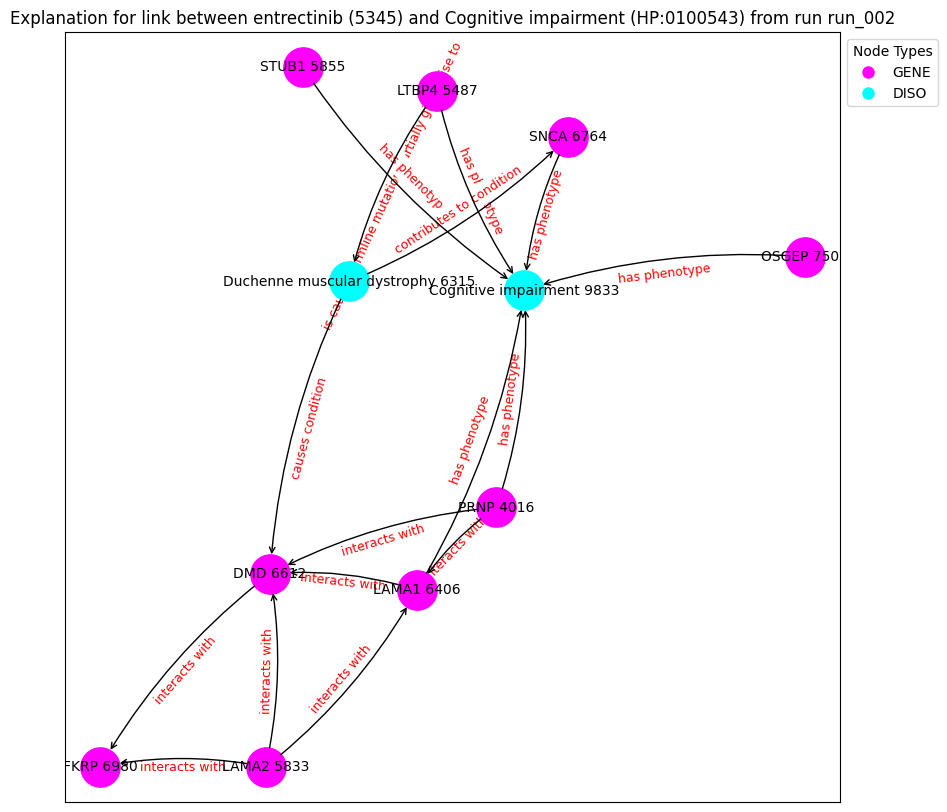

('PRNP 4016', {'type': 'GENE'})
('LTBP4 5487', {'type': 'GENE'})
('LAMA2 5833', {'type': 'GENE'})
('STUB1 5855', {'type': 'GENE'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('LAMA1 6406', {'type': 'GENE'})
('DMD 6612', {'type': 'GENE'})
('SNCA 6764', {'type': 'GENE'})
('FKRP 6980', {'type': 'GENE'})
('OSGEP 7508', {'type': 'GENE'})
('Cognitive impairment 9833', {'type': 'DISO'})
('PRNP 4016', 'DMD 6612', {'label': 'interacts with'})
('PRNP 4016', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('PRNP 4016', 'LAMA1 6406', {'label': 'interacts with'})
('LTBP4 5487', 'Duchenne muscular dystrophy 6315', {'label': 'is causal germline mutation partially giving rise to'})
('LTBP4 5487', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('LAMA2 5833', 'DMD 6612', {'label': 'interacts with'})
('LAMA2 5833', 'FKRP 6980', {'label': 'interacts with'})
('LAMA2 5833', 'LAMA1 6406', {'label': 'interacts with'})
('STUB1 5855', 'Cognitive impairment 9833', {'label': 'has ph

Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 478.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 489.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 530.21it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 526.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5297], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 469.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 469.37it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5538], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 437.39it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5009], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 477.90it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 485.10it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5162], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 397.32it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


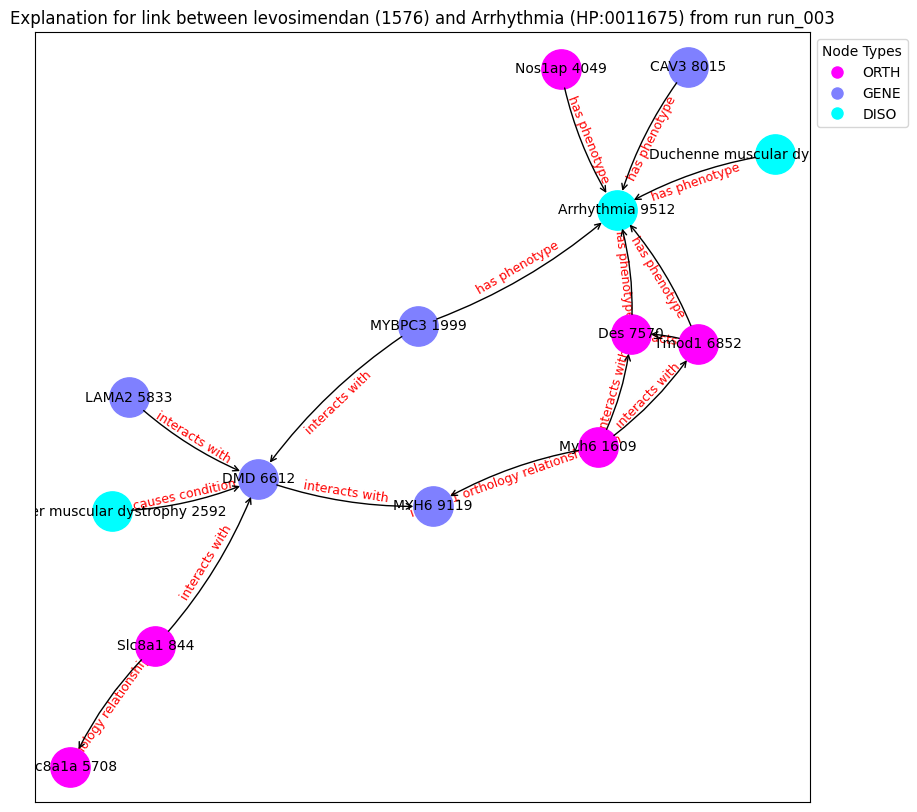

('Slc8a1 844', {'type': 'ORTH'})
('Myh6 1609', {'type': 'ORTH'})
('MYBPC3 1999', {'type': 'GENE'})
('Becker muscular dystrophy 2592', {'type': 'DISO'})
('Nos1ap 4049', {'type': 'ORTH'})
('slc8a1a 5708', {'type': 'ORTH'})
('LAMA2 5833', {'type': 'GENE'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('DMD 6612', {'type': 'GENE'})
('Tmod1 6852', {'type': 'ORTH'})
('Des 7570', {'type': 'ORTH'})
('CAV3 8015', {'type': 'GENE'})
('MYH6 9119', {'type': 'GENE'})
('Arrhythmia 9512', {'type': 'DISO'})
('Slc8a1 844', 'DMD 6612', {'label': 'interacts with'})
('Slc8a1 844', 'slc8a1a 5708', {'label': 'in orthology relationship with'})
('Myh6 1609', 'Tmod1 6852', {'label': 'interacts with'})
('Myh6 1609', 'MYH6 9119', {'label': 'in 1 to 1 orthology relationship with'})
('Myh6 1609', 'Des 7570', {'label': 'interacts with'})
('MYBPC3 1999', 'DMD 6612', {'label': 'interacts with'})
('MYBPC3 1999', 'Arrhythmia 9512', {'label': 'has phenotype'})
('Becker muscular dystrophy 2592', 'DMD 6612', {'la

Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 460.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 509.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 431.62it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 433.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 386.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5413], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 437.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 433.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 467.28it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 461.08it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 487.84it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


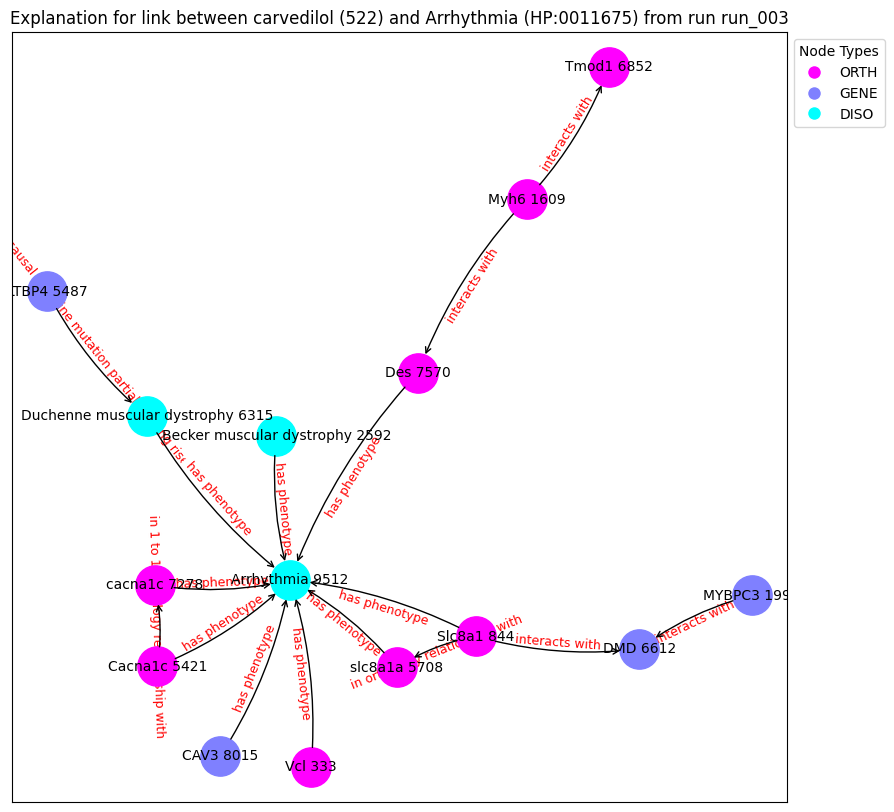

('Vcl 333', {'type': 'ORTH'})
('Slc8a1 844', {'type': 'ORTH'})
('Myh6 1609', {'type': 'ORTH'})
('MYBPC3 1999', {'type': 'GENE'})
('Becker muscular dystrophy 2592', {'type': 'DISO'})
('Cacna1c 5421', {'type': 'ORTH'})
('LTBP4 5487', {'type': 'GENE'})
('slc8a1a 5708', {'type': 'ORTH'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('DMD 6612', {'type': 'GENE'})
('Tmod1 6852', {'type': 'ORTH'})
('cacna1c 7278', {'type': 'ORTH'})
('Des 7570', {'type': 'ORTH'})
('CAV3 8015', {'type': 'GENE'})
('Arrhythmia 9512', {'type': 'DISO'})
('Vcl 333', 'Arrhythmia 9512', {'label': 'has phenotype'})
('Slc8a1 844', 'DMD 6612', {'label': 'interacts with'})
('Slc8a1 844', 'slc8a1a 5708', {'label': 'in orthology relationship with'})
('Slc8a1 844', 'Arrhythmia 9512', {'label': 'has phenotype'})
('Myh6 1609', 'Tmod1 6852', {'label': 'interacts with'})
('Myh6 1609', 'Des 7570', {'label': 'interacts with'})
('MYBPC3 1999', 'DMD 6612', {'label': 'interacts with'})
('Becker muscular dystrophy 2592', 'Ar

Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 489.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 555.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6608], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 516.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 525.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 583.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 520.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6266], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 447.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 487.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 583.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 537.82it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic                          label  \
4247      4247  HP:0001256     DISO  Intellectual disability, mild   

      semantic_id  
4247            1  
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.7815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 536.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 591.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 567.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 472.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 577.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 639.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 600.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 464.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8029], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 619.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 608.92it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic               label  semantic_id
2788      2788  HP:0003560     DISO  Muscular dystrophy            1
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.5650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 396.77it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 463.16it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 483.37it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 419.37it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 431.76it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 465.59it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6181], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 495.21it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6311], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 462.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 496.02it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6338], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 458.61it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


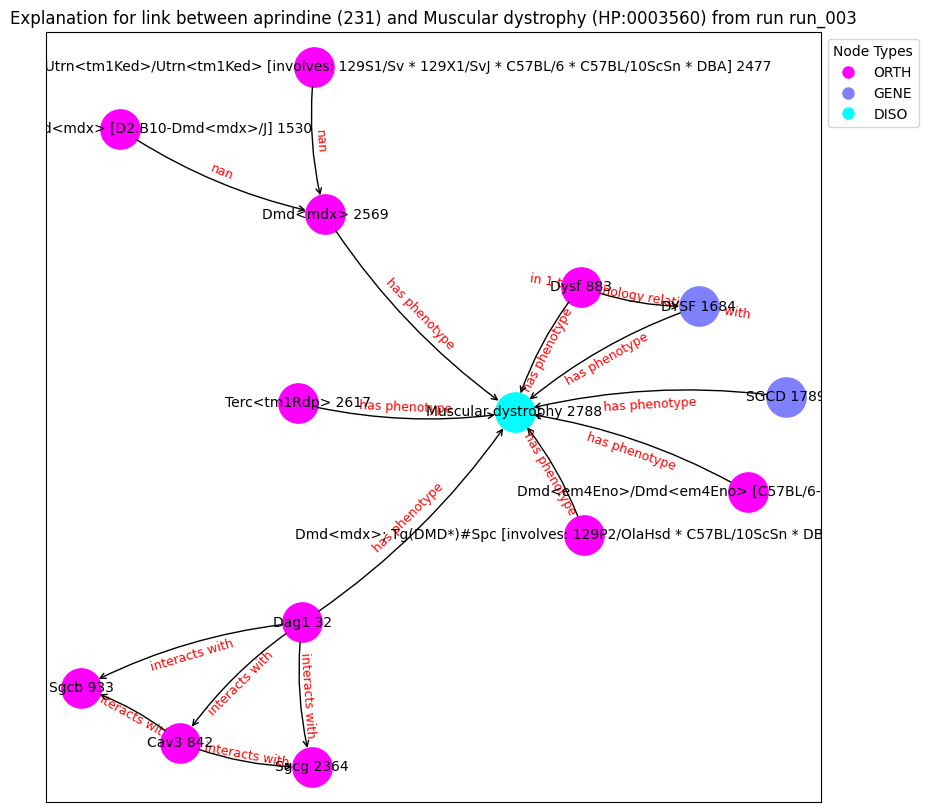

('Dmd<mdx>; Tg(DMD*)#Spc [involves: 129P2/OlaHsd * C57BL/10ScSn * DBA/2] 20', {'type': 'ORTH'})
('Dag1 32', {'type': 'ORTH'})
('Cav3 842', {'type': 'ORTH'})
('Dysf 883', {'type': 'ORTH'})
('Sgcb 933', {'type': 'ORTH'})
('Dmd<mdx>/Dmd<mdx> [D2.B10-Dmd<mdx>/J] 1530', {'type': 'ORTH'})
('DYSF 1684', {'type': 'GENE'})
('SGCD 1789', {'type': 'GENE'})
('Sgcg 2364', {'type': 'ORTH'})
('Dmd<em4Eno>/Dmd<em4Eno> [C57BL/6-Dmd<em4Eno>] 2448', {'type': 'ORTH'})
('Dmd<mdx>/Dmd<mdx>; Utrn<tm1Ked>/Utrn<tm1Ked> [involves: 129S1/Sv * 129X1/SvJ * C57BL/6 * C57BL/10ScSn * DBA] 2477', {'type': 'ORTH'})
('Dmd<mdx> 2569', {'type': 'ORTH'})
('Terc<tm1Rdp> 2617', {'type': 'ORTH'})
('Muscular dystrophy 2788', {'type': 'DISO'})
('Dmd<mdx>; Tg(DMD*)#Spc [involves: 129P2/OlaHsd * C57BL/10ScSn * DBA/2] 20', 'Muscular dystrophy 2788', {'label': 'has phenotype'})
('Dag1 32', 'Muscular dystrophy 2788', {'label': 'has phenotype'})
('Dag1 32', 'Cav3 842', {'label': 'interacts with'})
('Dag1 32', 'Sgcb 933', {'label': 'i

Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 427.79it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 374.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 445.78it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 405.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 428.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 436.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 424.97it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 459.78it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 367.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5982], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 466.80it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


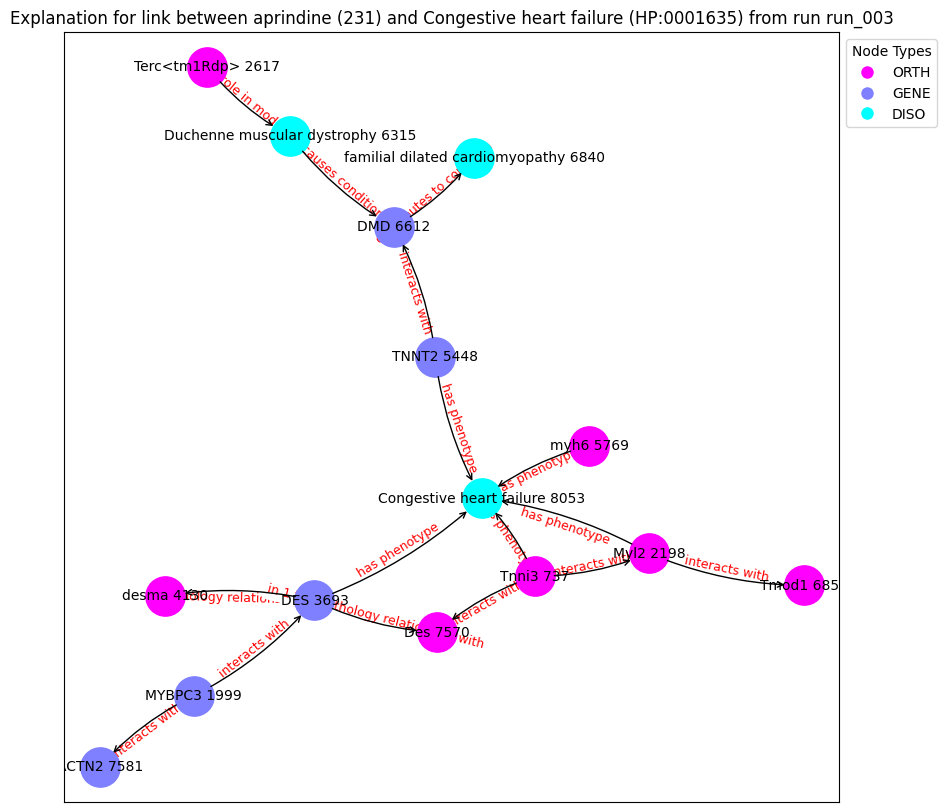

('Tnni3 737', {'type': 'ORTH'})
('MYBPC3 1999', {'type': 'GENE'})
('Myl2 2198', {'type': 'ORTH'})
('Terc<tm1Rdp> 2617', {'type': 'ORTH'})
('DES 3693', {'type': 'GENE'})
('desma 4130', {'type': 'ORTH'})
('TNNT2 5448', {'type': 'GENE'})
('myh6 5769', {'type': 'ORTH'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('DMD 6612', {'type': 'GENE'})
('familial dilated cardiomyopathy 6840', {'type': 'DISO'})
('Tmod1 6852', {'type': 'ORTH'})
('Des 7570', {'type': 'ORTH'})
('ACTN2 7581', {'type': 'GENE'})
('Congestive heart failure 8053', {'type': 'DISO'})
('Tnni3 737', 'Myl2 2198', {'label': 'interacts with'})
('Tnni3 737', 'Des 7570', {'label': 'interacts with'})
('Tnni3 737', 'Congestive heart failure 8053', {'label': 'has phenotype'})
('MYBPC3 1999', 'DES 3693', {'label': 'interacts with'})
('MYBPC3 1999', 'ACTN2 7581', {'label': 'interacts with'})
('Myl2 2198', 'Tmod1 6852', {'label': 'interacts with'})
('Myl2 2198', 'Congestive heart failure 8053', {'label': 'has phenotype'})
('Ter

Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 542.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5349], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 448.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4976], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 580.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5132], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 628.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5825], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 602.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 665.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6543], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 610.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 679.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 647.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6406], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 659.14it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic                label  semantic_id
4563      4563  HP:0001371     DISO  Flexion contracture            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.8242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 578.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7362], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 606.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 594.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 600.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 585.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7271], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 493.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 553.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 583.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 590.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 609.43it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic      label  semantic_id
4273      4273  HP:0002650     DISO  Scoliosis            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.7980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 560.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 561.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7742], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 555.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 569.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7834], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 561.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7258], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 568.42it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 530.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 427.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 487.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 542.16it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


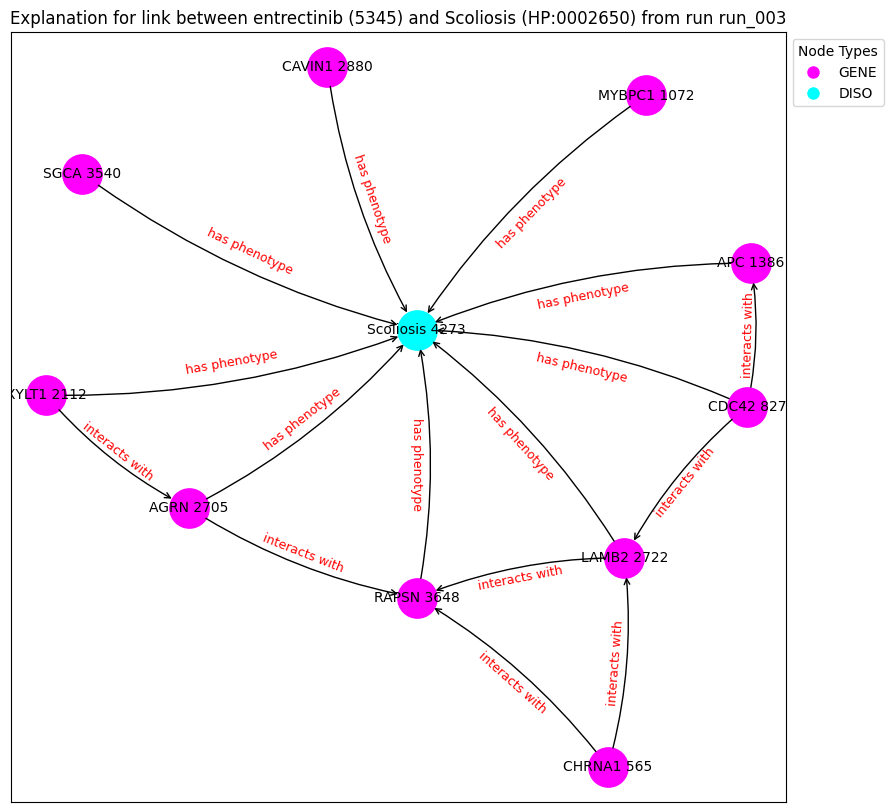

('CHRNA1 565', {'type': 'GENE'})
('CDC42 827', {'type': 'GENE'})
('MYBPC1 1072', {'type': 'GENE'})
('APC 1386', {'type': 'GENE'})
('XYLT1 2112', {'type': 'GENE'})
('AGRN 2705', {'type': 'GENE'})
('LAMB2 2722', {'type': 'GENE'})
('CAVIN1 2880', {'type': 'GENE'})
('SGCA 3540', {'type': 'GENE'})
('RAPSN 3648', {'type': 'GENE'})
('Scoliosis 4273', {'type': 'DISO'})
('CHRNA1 565', 'LAMB2 2722', {'label': 'interacts with'})
('CHRNA1 565', 'RAPSN 3648', {'label': 'interacts with'})
('CDC42 827', 'LAMB2 2722', {'label': 'interacts with'})
('CDC42 827', 'APC 1386', {'label': 'interacts with'})
('CDC42 827', 'Scoliosis 4273', {'label': 'has phenotype'})
('MYBPC1 1072', 'Scoliosis 4273', {'label': 'has phenotype'})
('APC 1386', 'Scoliosis 4273', {'label': 'has phenotype'})
('XYLT1 2112', 'AGRN 2705', {'label': 'interacts with'})
('XYLT1 2112', 'Scoliosis 4273', {'label': 'has phenotype'})
('AGRN 2705', 'RAPSN 3648', {'label': 'interacts with'})
('AGRN 2705', 'Scoliosis 4273', {'label': 'has pheno

Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 381.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5105], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 517.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 528.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5758], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 594.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6170], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 608.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4945], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 387.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4503], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 499.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 579.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 568.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6474], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 556.57it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic           label  semantic_id
1379      1379  HP:0001638     DISO  Cardiomyopathy            1
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.5356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 595.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 579.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5759], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 510.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6655], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 577.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5641], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 580.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 559.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5151], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 553.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 550.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 500.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 551.79it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic        label  semantic_id
1333      1333  HP:0001270     DISO  Motor delay            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.6076], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 549.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 620.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 642.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 649.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5117], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 581.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 582.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6585], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 604.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 633.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 499.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 508.05it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic                 label  semantic_id
9833      9833  HP:0100543     DISO  Cognitive impairment            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.5170], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 498.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 558.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 564.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 542.44it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5572], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 473.82it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 456.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 559.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5549], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 551.75it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 483.67it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 480.57it/s]


Contribution threshold is tensor(0.0062)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


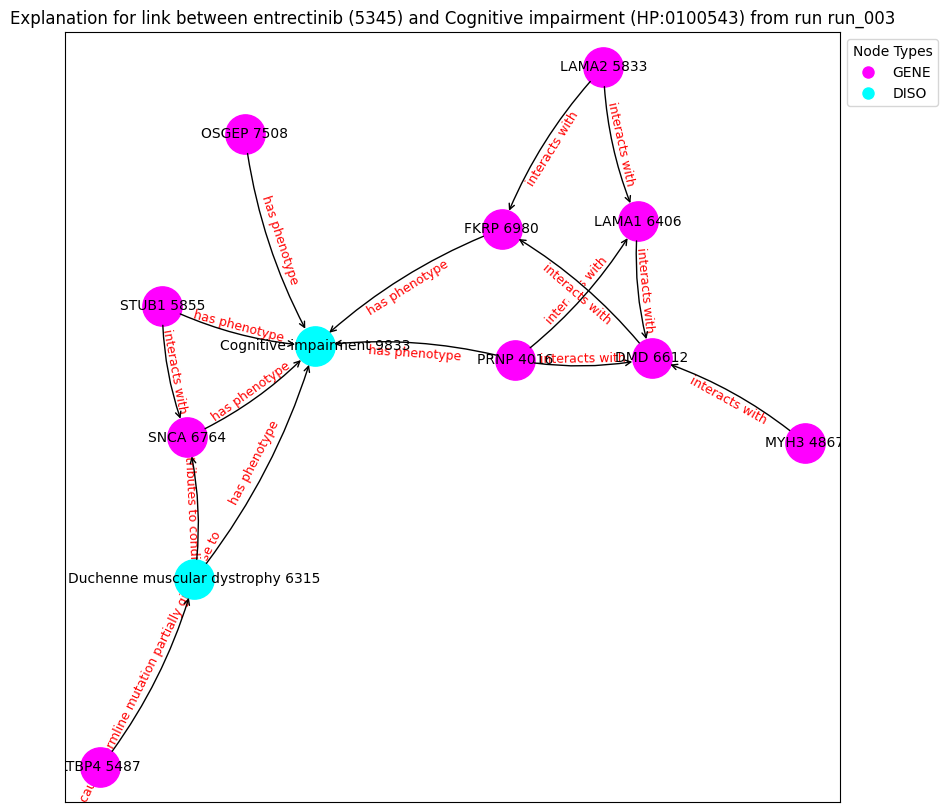

('PRNP 4016', {'type': 'GENE'})
('MYH3 4867', {'type': 'GENE'})
('LTBP4 5487', {'type': 'GENE'})
('LAMA2 5833', {'type': 'GENE'})
('STUB1 5855', {'type': 'GENE'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('LAMA1 6406', {'type': 'GENE'})
('DMD 6612', {'type': 'GENE'})
('SNCA 6764', {'type': 'GENE'})
('FKRP 6980', {'type': 'GENE'})
('OSGEP 7508', {'type': 'GENE'})
('Cognitive impairment 9833', {'type': 'DISO'})
('PRNP 4016', 'DMD 6612', {'label': 'interacts with'})
('PRNP 4016', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('PRNP 4016', 'LAMA1 6406', {'label': 'interacts with'})
('MYH3 4867', 'DMD 6612', {'label': 'interacts with'})
('LTBP4 5487', 'Duchenne muscular dystrophy 6315', {'label': 'is causal germline mutation partially giving rise to'})
('LAMA2 5833', 'FKRP 6980', {'label': 'interacts with'})
('LAMA2 5833', 'LAMA1 6406', {'label': 'interacts with'})
('STUB1 5855', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('STUB1 5855', 'SNCA 6764', {'

Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 475.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 459.84it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 499.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6217], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 491.63it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 434.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 476.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 395.91it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7255], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 491.36it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 476.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 510.50it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


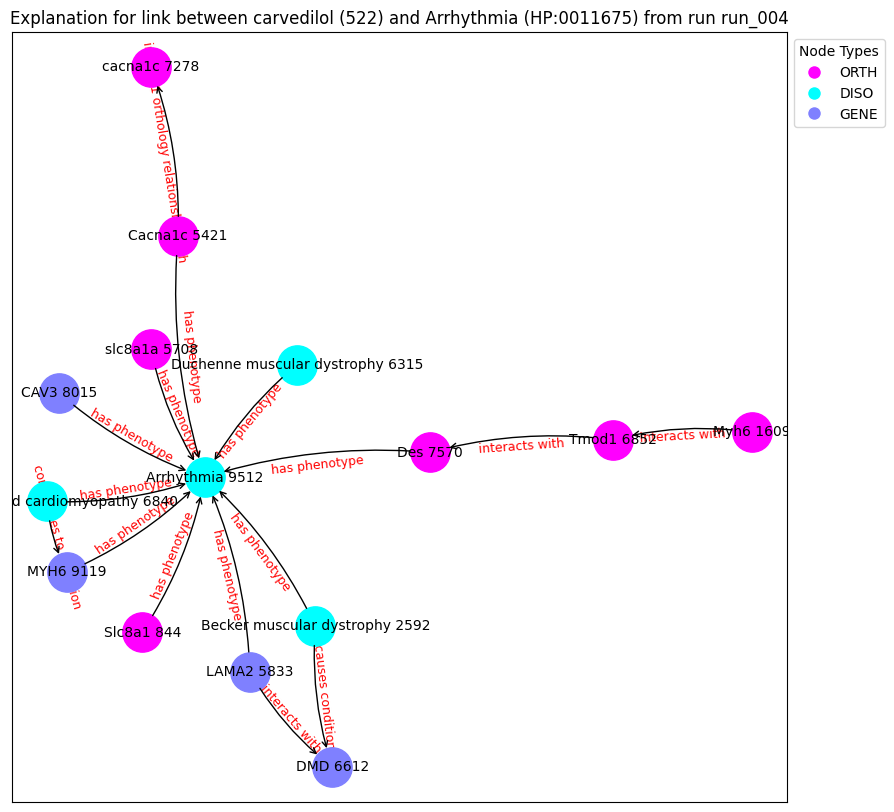

('Slc8a1 844', {'type': 'ORTH'})
('Myh6 1609', {'type': 'ORTH'})
('Becker muscular dystrophy 2592', {'type': 'DISO'})
('Cacna1c 5421', {'type': 'ORTH'})
('slc8a1a 5708', {'type': 'ORTH'})
('LAMA2 5833', {'type': 'GENE'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('DMD 6612', {'type': 'GENE'})
('familial dilated cardiomyopathy 6840', {'type': 'DISO'})
('Tmod1 6852', {'type': 'ORTH'})
('cacna1c 7278', {'type': 'ORTH'})
('Des 7570', {'type': 'ORTH'})
('CAV3 8015', {'type': 'GENE'})
('MYH6 9119', {'type': 'GENE'})
('Arrhythmia 9512', {'type': 'DISO'})
('Slc8a1 844', 'Arrhythmia 9512', {'label': 'has phenotype'})
('Myh6 1609', 'Tmod1 6852', {'label': 'interacts with'})
('Becker muscular dystrophy 2592', 'DMD 6612', {'label': 'causes condition'})
('Becker muscular dystrophy 2592', 'Arrhythmia 9512', {'label': 'has phenotype'})
('Cacna1c 5421', 'cacna1c 7278', {'label': 'in 1 to 1 orthology relationship with'})
('Cacna1c 5421', 'Arrhythmia 9512', {'label': 'has phenotype'})
('slc

Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 447.70it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6222], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 436.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6071], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 491.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 440.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 445.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5968], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 509.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6093], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 495.69it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5366], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 509.87it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 520.78it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6882], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 495.90it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


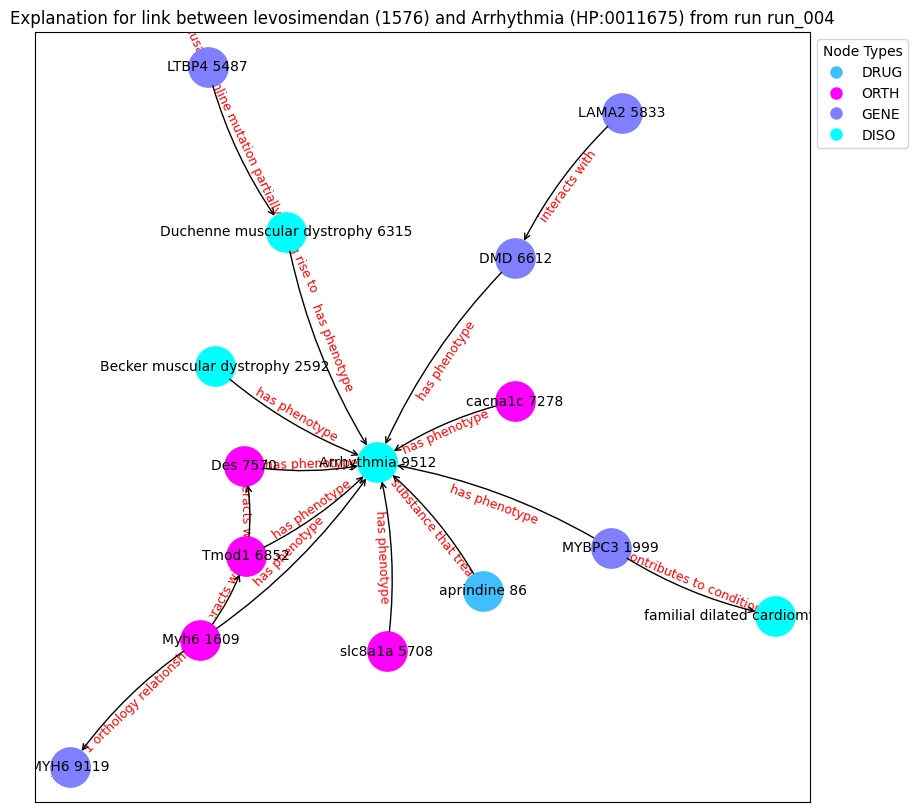

('aprindine 86', {'type': 'DRUG'})
('Myh6 1609', {'type': 'ORTH'})
('MYBPC3 1999', {'type': 'GENE'})
('Becker muscular dystrophy 2592', {'type': 'DISO'})
('LTBP4 5487', {'type': 'GENE'})
('slc8a1a 5708', {'type': 'ORTH'})
('LAMA2 5833', {'type': 'GENE'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('DMD 6612', {'type': 'GENE'})
('familial dilated cardiomyopathy 6840', {'type': 'DISO'})
('Tmod1 6852', {'type': 'ORTH'})
('cacna1c 7278', {'type': 'ORTH'})
('Des 7570', {'type': 'ORTH'})
('MYH6 9119', {'type': 'GENE'})
('Arrhythmia 9512', {'type': 'DISO'})
('aprindine 86', 'Arrhythmia 9512', {'label': 'is substance that treats'})
('Myh6 1609', 'Tmod1 6852', {'label': 'interacts with'})
('Myh6 1609', 'MYH6 9119', {'label': 'in 1 to 1 orthology relationship with'})
('Myh6 1609', 'Arrhythmia 9512', {'label': 'has phenotype'})
('MYBPC3 1999', 'Arrhythmia 9512', {'label': 'has phenotype'})
('MYBPC3 1999', 'familial dilated cardiomyopathy 6840', {'label': 'contributes to condition'})
(

Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 577.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 525.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 455.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3633], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 468.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4266], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 478.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 447.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 394.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3257], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 440.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4674], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 506.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 509.72it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic                          label  \
4247      4247  HP:0001256     DISO  Intellectual disability, mild   

      semantic_id  
4247            1  
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.5725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 540.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5323], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 495.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6133], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 504.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5649], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 557.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 508.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5882], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 597.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 591.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 539.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5792], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 452.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5130], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 529.65it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic               label  semantic_id
2788      2788  HP:0003560     DISO  Muscular dystrophy            1
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.4443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:02<00:00, 289.63it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 370.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4362], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:02<00:00, 320.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 401.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3974], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 477.84it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3782], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 495.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3827], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 444.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 395.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 476.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3048], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 488.19it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


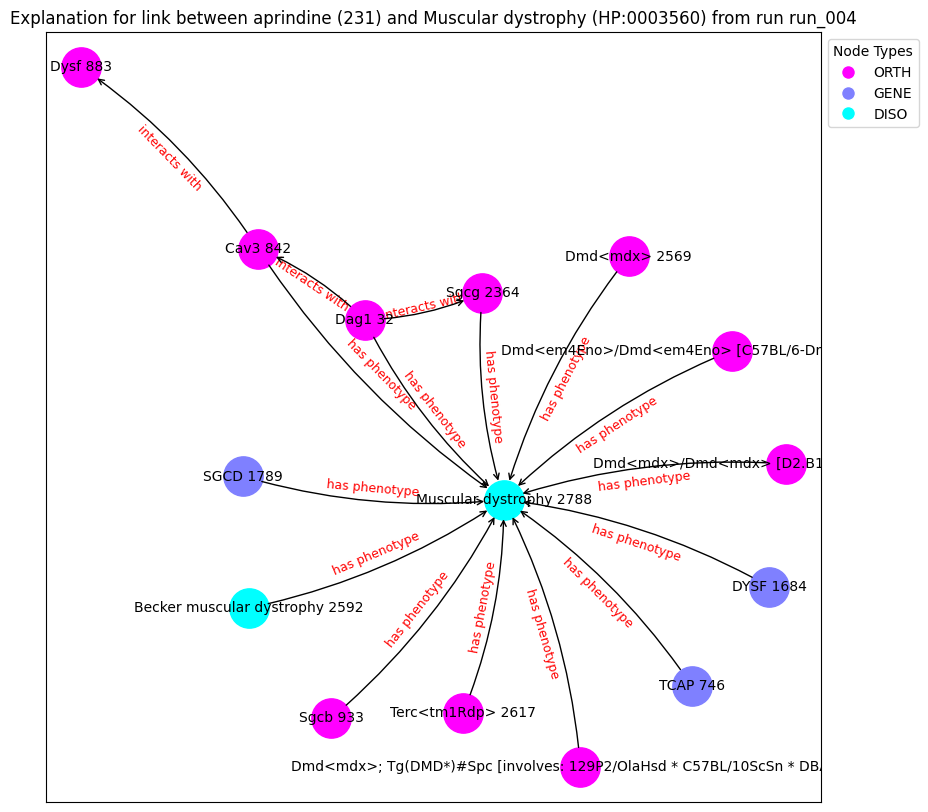

('Dmd<mdx>; Tg(DMD*)#Spc [involves: 129P2/OlaHsd * C57BL/10ScSn * DBA/2] 20', {'type': 'ORTH'})
('Dag1 32', {'type': 'ORTH'})
('TCAP 746', {'type': 'GENE'})
('Cav3 842', {'type': 'ORTH'})
('Dysf 883', {'type': 'ORTH'})
('Sgcb 933', {'type': 'ORTH'})
('Dmd<mdx>/Dmd<mdx> [D2.B10-Dmd<mdx>/J] 1530', {'type': 'ORTH'})
('DYSF 1684', {'type': 'GENE'})
('SGCD 1789', {'type': 'GENE'})
('Sgcg 2364', {'type': 'ORTH'})
('Dmd<em4Eno>/Dmd<em4Eno> [C57BL/6-Dmd<em4Eno>] 2448', {'type': 'ORTH'})
('Dmd<mdx> 2569', {'type': 'ORTH'})
('Becker muscular dystrophy 2592', {'type': 'DISO'})
('Terc<tm1Rdp> 2617', {'type': 'ORTH'})
('Muscular dystrophy 2788', {'type': 'DISO'})
('Dmd<mdx>; Tg(DMD*)#Spc [involves: 129P2/OlaHsd * C57BL/10ScSn * DBA/2] 20', 'Muscular dystrophy 2788', {'label': 'has phenotype'})
('Dag1 32', 'Muscular dystrophy 2788', {'label': 'has phenotype'})
('Dag1 32', 'Cav3 842', {'label': 'interacts with'})
('Dag1 32', 'Sgcg 2364', {'label': 'interacts with'})
('TCAP 746', 'Muscular dystrophy 2

Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 394.76it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 384.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4522], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:02<00:00, 346.12it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5206], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:02<00:00, 343.99it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:02<00:00, 292.86it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 428.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4734], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 434.77it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3626], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 457.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 466.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 469.43it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


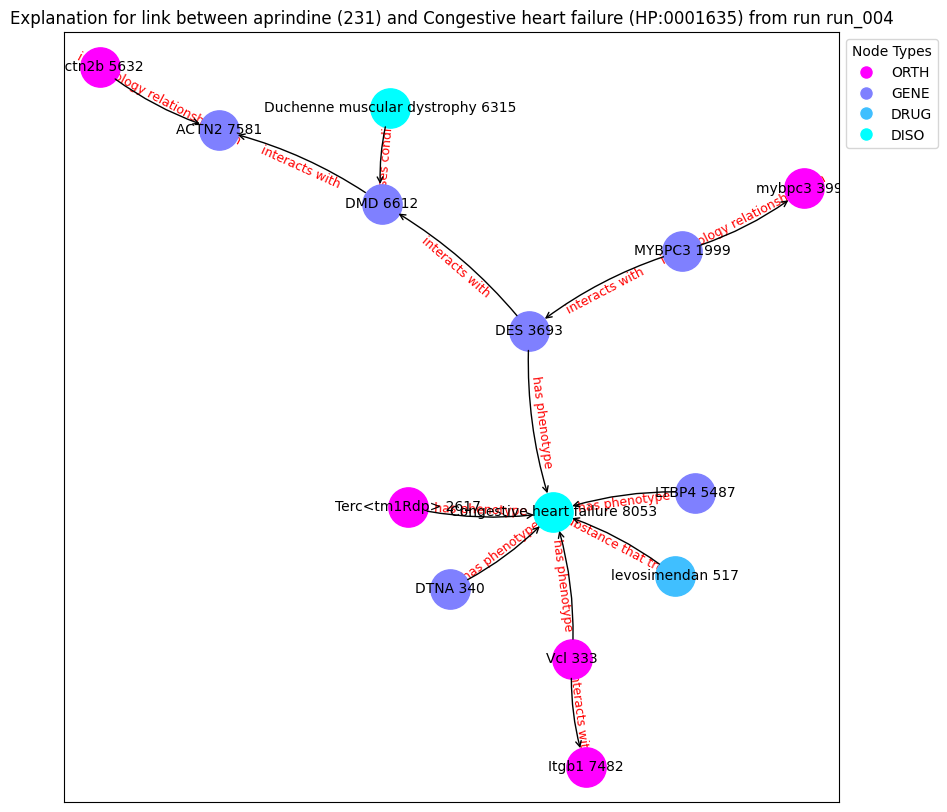

('Vcl 333', {'type': 'ORTH'})
('DTNA 340', {'type': 'GENE'})
('levosimendan 517', {'type': 'DRUG'})
('MYBPC3 1999', {'type': 'GENE'})
('Terc<tm1Rdp> 2617', {'type': 'ORTH'})
('DES 3693', {'type': 'GENE'})
('mybpc3 3990', {'type': 'ORTH'})
('LTBP4 5487', {'type': 'GENE'})
('actn2b 5632', {'type': 'ORTH'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('DMD 6612', {'type': 'GENE'})
('Itgb1 7482', {'type': 'ORTH'})
('ACTN2 7581', {'type': 'GENE'})
('Congestive heart failure 8053', {'type': 'DISO'})
('Vcl 333', 'Itgb1 7482', {'label': 'interacts with'})
('Vcl 333', 'Congestive heart failure 8053', {'label': 'has phenotype'})
('DTNA 340', 'Congestive heart failure 8053', {'label': 'has phenotype'})
('levosimendan 517', 'Congestive heart failure 8053', {'label': 'is substance that treats'})
('MYBPC3 1999', 'DES 3693', {'label': 'interacts with'})
('MYBPC3 1999', 'mybpc3 3990', {'label': 'in orthology relationship with'})
('Terc<tm1Rdp> 2617', 'Congestive heart failure 8053', {'label

Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 481.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 485.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5734], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 444.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 499.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 560.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 642.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 656.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 647.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 533.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5271], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 627.96it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic                label  semantic_id
4563      4563  HP:0001371     DISO  Flexion contracture            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.4588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 581.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 579.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 520.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 487.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:02<00:00, 347.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:02<00:00, 348.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 401.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 499.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5251], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 473.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6414], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 407.45it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic      label  semantic_id
4273      4273  HP:0002650     DISO  Scoliosis            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.5645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 471.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4898], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 514.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 528.88it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5487], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 515.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 549.38it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5538], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 498.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5905], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 471.95it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6545], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 502.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 366.76it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 472.10it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


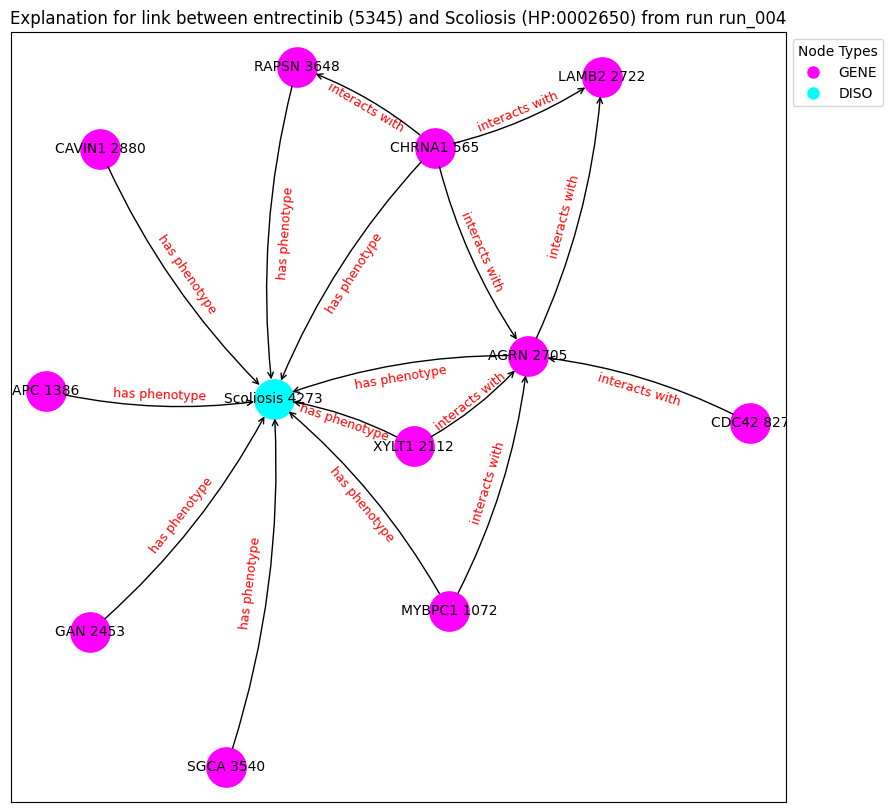

('CHRNA1 565', {'type': 'GENE'})
('CDC42 827', {'type': 'GENE'})
('MYBPC1 1072', {'type': 'GENE'})
('APC 1386', {'type': 'GENE'})
('XYLT1 2112', {'type': 'GENE'})
('GAN 2453', {'type': 'GENE'})
('AGRN 2705', {'type': 'GENE'})
('LAMB2 2722', {'type': 'GENE'})
('CAVIN1 2880', {'type': 'GENE'})
('SGCA 3540', {'type': 'GENE'})
('RAPSN 3648', {'type': 'GENE'})
('Scoliosis 4273', {'type': 'DISO'})
('CHRNA1 565', 'LAMB2 2722', {'label': 'interacts with'})
('CHRNA1 565', 'Scoliosis 4273', {'label': 'has phenotype'})
('CHRNA1 565', 'AGRN 2705', {'label': 'interacts with'})
('CHRNA1 565', 'RAPSN 3648', {'label': 'interacts with'})
('CDC42 827', 'AGRN 2705', {'label': 'interacts with'})
('MYBPC1 1072', 'AGRN 2705', {'label': 'interacts with'})
('MYBPC1 1072', 'Scoliosis 4273', {'label': 'has phenotype'})
('APC 1386', 'Scoliosis 4273', {'label': 'has phenotype'})
('XYLT1 2112', 'AGRN 2705', {'label': 'interacts with'})
('XYLT1 2112', 'Scoliosis 4273', {'label': 'has phenotype'})
('GAN 2453', 'Scol

Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 381.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 461.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 552.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 571.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 555.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3821], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 531.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 565.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4603], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 589.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 521.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5399], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 584.27it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic           label  semantic_id
1379      1379  HP:0001638     DISO  Cardiomyopathy            1
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.5909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 543.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 530.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5325], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 501.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 548.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 564.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 544.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 537.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 559.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4388], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 561.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 571.46it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic        label  semantic_id
1333      1333  HP:0001270     DISO  Motor delay            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.6346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 542.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 619.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 607.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 534.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 554.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5428], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 460.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 532.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6396], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 575.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 610.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 568.74it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic                 label  semantic_id
9833      9833  HP:0100543     DISO  Cognitive impairment            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.5492], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 525.37it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5176], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 494.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5616], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 431.84it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5541], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 523.75it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5276], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 553.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 552.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 560.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 503.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 547.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 484.82it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


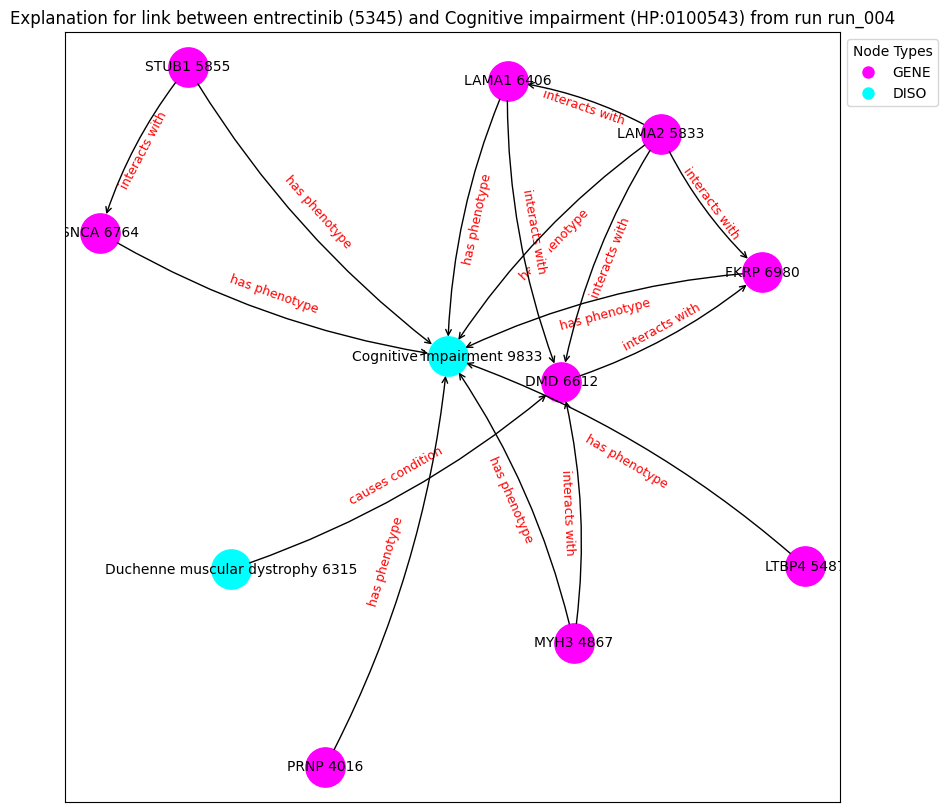

('PRNP 4016', {'type': 'GENE'})
('MYH3 4867', {'type': 'GENE'})
('LTBP4 5487', {'type': 'GENE'})
('LAMA2 5833', {'type': 'GENE'})
('STUB1 5855', {'type': 'GENE'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('LAMA1 6406', {'type': 'GENE'})
('DMD 6612', {'type': 'GENE'})
('SNCA 6764', {'type': 'GENE'})
('FKRP 6980', {'type': 'GENE'})
('Cognitive impairment 9833', {'type': 'DISO'})
('PRNP 4016', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('MYH3 4867', 'DMD 6612', {'label': 'interacts with'})
('MYH3 4867', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('LTBP4 5487', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('LAMA2 5833', 'DMD 6612', {'label': 'interacts with'})
('LAMA2 5833', 'FKRP 6980', {'label': 'interacts with'})
('LAMA2 5833', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('LAMA2 5833', 'LAMA1 6406', {'label': 'interacts with'})
('STUB1 5855', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('STUB1 5855', 'SNCA 6

Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 488.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 488.36it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 491.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 503.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3191], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 411.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:02<00:00, 345.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4355], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 498.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3437], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 448.47it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 498.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4130], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 447.77it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


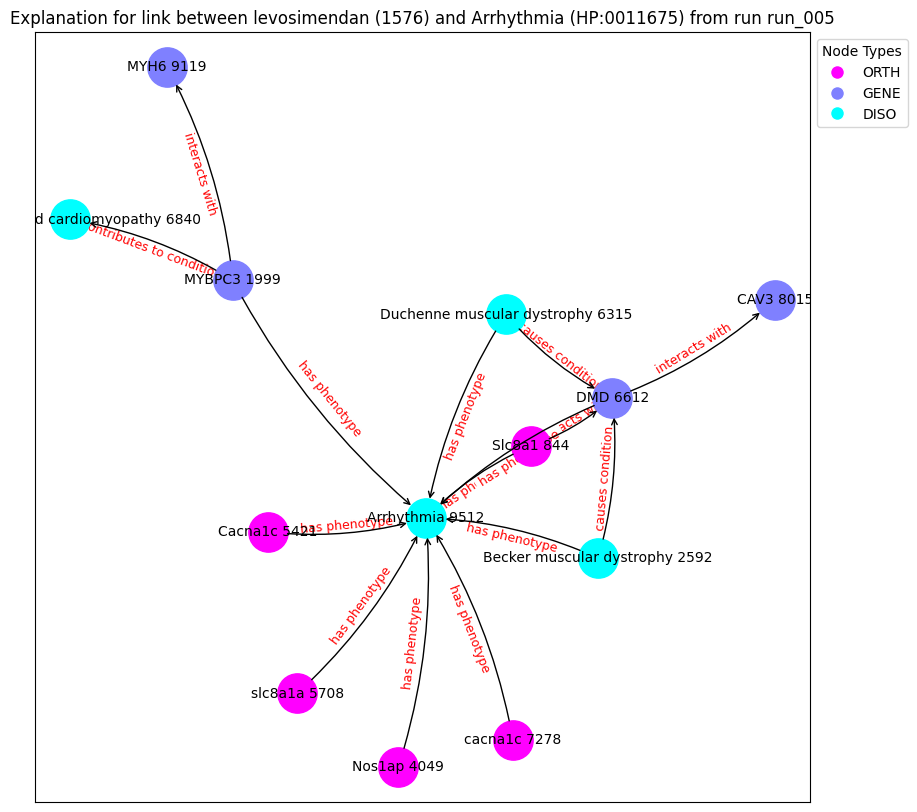

('Slc8a1 844', {'type': 'ORTH'})
('MYBPC3 1999', {'type': 'GENE'})
('Becker muscular dystrophy 2592', {'type': 'DISO'})
('Nos1ap 4049', {'type': 'ORTH'})
('Cacna1c 5421', {'type': 'ORTH'})
('slc8a1a 5708', {'type': 'ORTH'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('DMD 6612', {'type': 'GENE'})
('familial dilated cardiomyopathy 6840', {'type': 'DISO'})
('cacna1c 7278', {'type': 'ORTH'})
('CAV3 8015', {'type': 'GENE'})
('MYH6 9119', {'type': 'GENE'})
('Arrhythmia 9512', {'type': 'DISO'})
('Slc8a1 844', 'DMD 6612', {'label': 'interacts with'})
('Slc8a1 844', 'Arrhythmia 9512', {'label': 'has phenotype'})
('MYBPC3 1999', 'MYH6 9119', {'label': 'interacts with'})
('MYBPC3 1999', 'Arrhythmia 9512', {'label': 'has phenotype'})
('MYBPC3 1999', 'familial dilated cardiomyopathy 6840', {'label': 'contributes to condition'})
('Becker muscular dystrophy 2592', 'DMD 6612', {'label': 'causes condition'})
('Becker muscular dystrophy 2592', 'Arrhythmia 9512', {'label': 'has phenotype'})


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 437.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 384.81it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:02<00:00, 326.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 412.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 458.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 450.51it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5727], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 459.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 427.26it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 466.04it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 184: 100%|██████████| 700/700 [00:01<00:00, 350.22it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


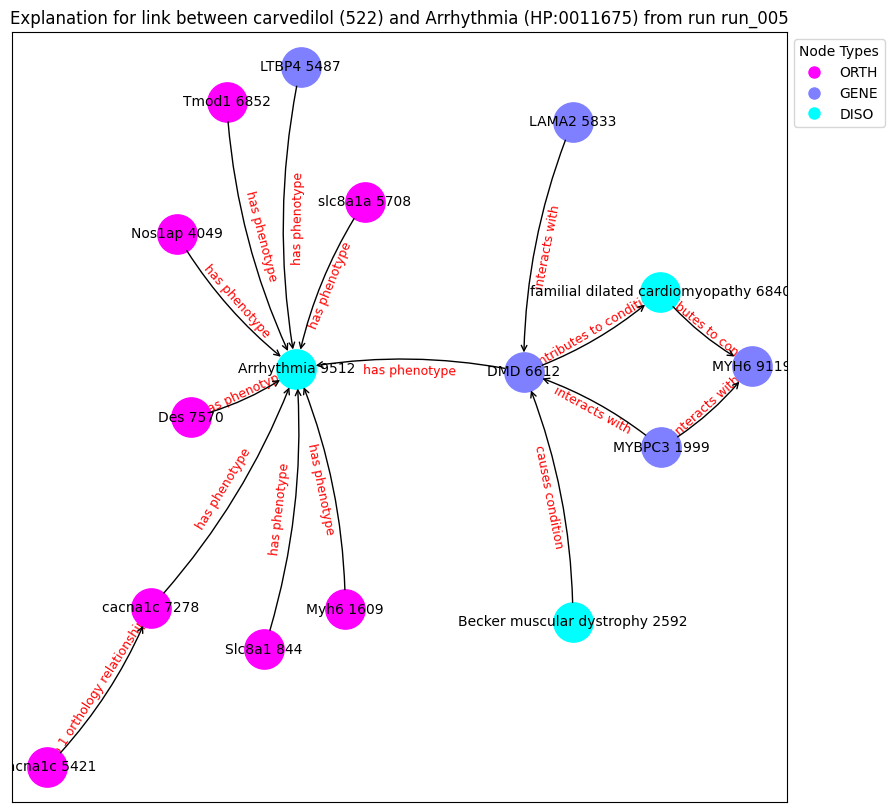

('Slc8a1 844', {'type': 'ORTH'})
('Myh6 1609', {'type': 'ORTH'})
('MYBPC3 1999', {'type': 'GENE'})
('Becker muscular dystrophy 2592', {'type': 'DISO'})
('Nos1ap 4049', {'type': 'ORTH'})
('Cacna1c 5421', {'type': 'ORTH'})
('LTBP4 5487', {'type': 'GENE'})
('slc8a1a 5708', {'type': 'ORTH'})
('LAMA2 5833', {'type': 'GENE'})
('DMD 6612', {'type': 'GENE'})
('familial dilated cardiomyopathy 6840', {'type': 'DISO'})
('Tmod1 6852', {'type': 'ORTH'})
('cacna1c 7278', {'type': 'ORTH'})
('Des 7570', {'type': 'ORTH'})
('MYH6 9119', {'type': 'GENE'})
('Arrhythmia 9512', {'type': 'DISO'})
('Slc8a1 844', 'Arrhythmia 9512', {'label': 'has phenotype'})
('Myh6 1609', 'Arrhythmia 9512', {'label': 'has phenotype'})
('MYBPC3 1999', 'MYH6 9119', {'label': 'interacts with'})
('MYBPC3 1999', 'DMD 6612', {'label': 'interacts with'})
('Becker muscular dystrophy 2592', 'DMD 6612', {'label': 'causes condition'})
('Nos1ap 4049', 'Arrhythmia 9512', {'label': 'has phenotype'})
('Cacna1c 5421', 'cacna1c 7278', {'label

Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 560.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8367], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 533.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 579.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 484.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5616], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 576.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 563.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 503.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 599.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7275], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 538.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 565.53it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic                          label  \
4247      4247  HP:0001256     DISO  Intellectual disability, mild   

      semantic_id  
4247            1  
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.8066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 686.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 573.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 603.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 542.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 681.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5054], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 675.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 656.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 696.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8905], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 685.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 676.23it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic               label  semantic_id
2788      2788  HP:0003560     DISO  Muscular dystrophy            1
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.8163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 557.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 573.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8114], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 563.85it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 548.88it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 553.44it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8087], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 563.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 527.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 519.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6185], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 536.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6626], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 564.00it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


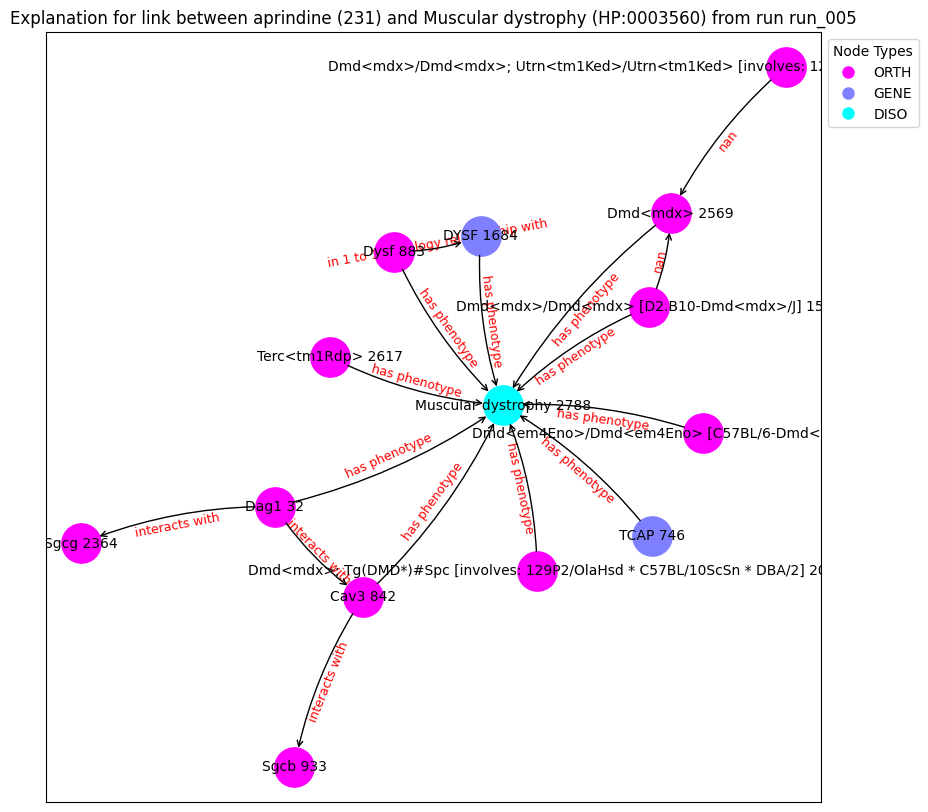

('Dmd<mdx>; Tg(DMD*)#Spc [involves: 129P2/OlaHsd * C57BL/10ScSn * DBA/2] 20', {'type': 'ORTH'})
('Dag1 32', {'type': 'ORTH'})
('TCAP 746', {'type': 'GENE'})
('Cav3 842', {'type': 'ORTH'})
('Dysf 883', {'type': 'ORTH'})
('Sgcb 933', {'type': 'ORTH'})
('Dmd<mdx>/Dmd<mdx> [D2.B10-Dmd<mdx>/J] 1530', {'type': 'ORTH'})
('DYSF 1684', {'type': 'GENE'})
('Sgcg 2364', {'type': 'ORTH'})
('Dmd<em4Eno>/Dmd<em4Eno> [C57BL/6-Dmd<em4Eno>] 2448', {'type': 'ORTH'})
('Dmd<mdx>/Dmd<mdx>; Utrn<tm1Ked>/Utrn<tm1Ked> [involves: 129S1/Sv * 129X1/SvJ * C57BL/6 * C57BL/10ScSn * DBA] 2477', {'type': 'ORTH'})
('Dmd<mdx> 2569', {'type': 'ORTH'})
('Terc<tm1Rdp> 2617', {'type': 'ORTH'})
('Muscular dystrophy 2788', {'type': 'DISO'})
('Dmd<mdx>; Tg(DMD*)#Spc [involves: 129P2/OlaHsd * C57BL/10ScSn * DBA/2] 20', 'Muscular dystrophy 2788', {'label': 'has phenotype'})
('Dag1 32', 'Muscular dystrophy 2788', {'label': 'has phenotype'})
('Dag1 32', 'Cav3 842', {'label': 'interacts with'})
('Dag1 32', 'Sgcg 2364', {'label': 'i

Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 465.78it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 456.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 388.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 399.10it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 428.48it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 431.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 431.87it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 473.85it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 476.48it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6341], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 483.25it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


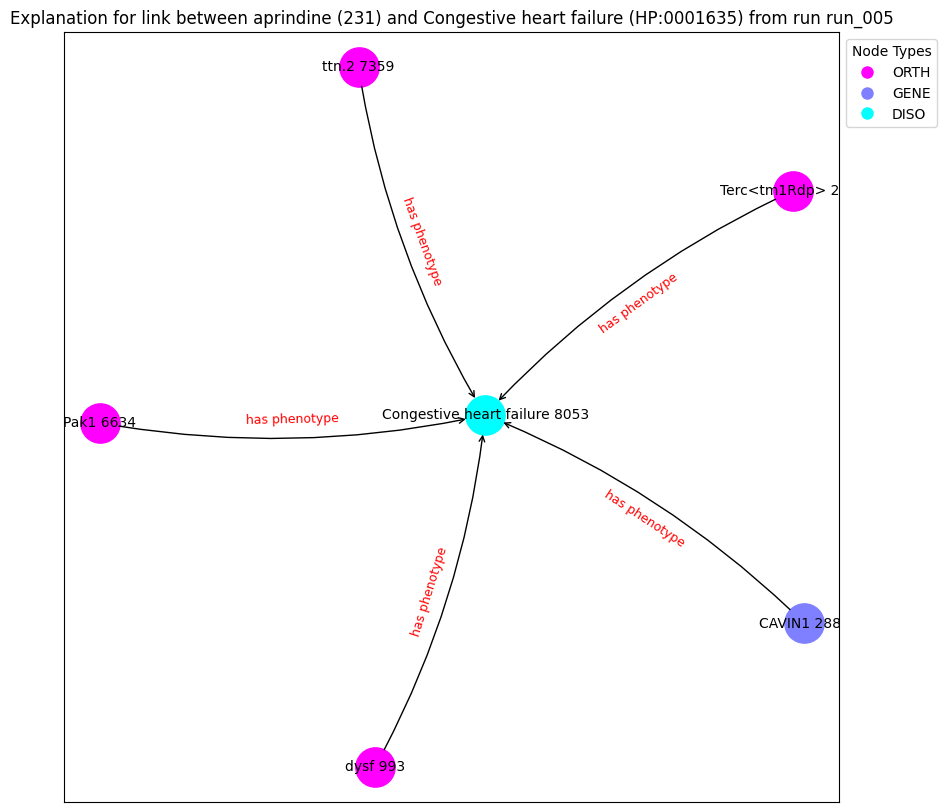

('dysf 993', {'type': 'ORTH'})
('Terc<tm1Rdp> 2617', {'type': 'ORTH'})
('CAVIN1 2880', {'type': 'GENE'})
('Pak1 6634', {'type': 'ORTH'})
('ttn.2 7359', {'type': 'ORTH'})
('Congestive heart failure 8053', {'type': 'DISO'})
('dysf 993', 'Congestive heart failure 8053', {'label': 'has phenotype'})
('Terc<tm1Rdp> 2617', 'Congestive heart failure 8053', {'label': 'has phenotype'})
('CAVIN1 2880', 'Congestive heart failure 8053', {'label': 'has phenotype'})
('Pak1 6634', 'Congestive heart failure 8053', {'label': 'has phenotype'})
('ttn.2 7359', 'Congestive heart failure 8053', {'label': 'has phenotype'})
Explanation graph saved at c:\Users\rosa-\Google Drive\Msc_Bioinformatics\thesis\XAIFO-ThesisProject\output\g1_e2v\expl_9/incomplete_explanation_4_run_005_graph.gpickle
Explanation pair ids and names saved at c:\Users\rosa-\Google Drive\Msc_Bioinformatics\thesis\XAIFO-ThesisProject\output\g1_e2v\expl_9/incomplete_explanation_4_run_005_pair.pkl
node1:
     index_id          id semantic      

Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 670.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 672.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8754], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 686.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 634.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7657], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 691.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 691.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8050], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 686.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 607.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 674.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:00<00:00, 702.68it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic                label  semantic_id
4563      4563  HP:0001371     DISO  Flexion contracture            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.4327], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 616.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 625.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:02<00:00, 303.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 350.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 464.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 495.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 489.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4617], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 503.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 478.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 439.72it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic      label  semantic_id
4273      4273  HP:0002650     DISO  Scoliosis            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.4853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 490.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 518.31it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 504.91it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 435.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5779], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 482.26it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8050], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 509.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 506.91it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6528], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 505.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7422], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 491.79it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1796: 100%|██████████| 700/700 [00:01<00:00, 508.48it/s]


Contribution threshold is tensor(0.0062)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


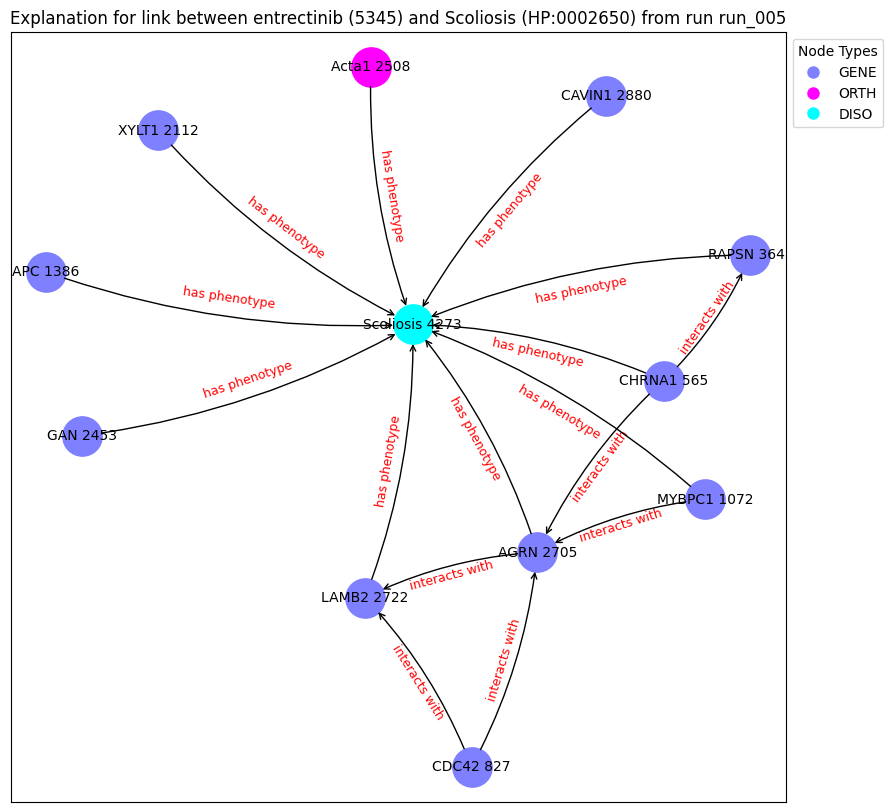

('CHRNA1 565', {'type': 'GENE'})
('CDC42 827', {'type': 'GENE'})
('MYBPC1 1072', {'type': 'GENE'})
('APC 1386', {'type': 'GENE'})
('XYLT1 2112', {'type': 'GENE'})
('GAN 2453', {'type': 'GENE'})
('Acta1 2508', {'type': 'ORTH'})
('AGRN 2705', {'type': 'GENE'})
('LAMB2 2722', {'type': 'GENE'})
('CAVIN1 2880', {'type': 'GENE'})
('RAPSN 3648', {'type': 'GENE'})
('Scoliosis 4273', {'type': 'DISO'})
('CHRNA1 565', 'Scoliosis 4273', {'label': 'has phenotype'})
('CHRNA1 565', 'AGRN 2705', {'label': 'interacts with'})
('CHRNA1 565', 'RAPSN 3648', {'label': 'interacts with'})
('CDC42 827', 'LAMB2 2722', {'label': 'interacts with'})
('CDC42 827', 'AGRN 2705', {'label': 'interacts with'})
('MYBPC1 1072', 'AGRN 2705', {'label': 'interacts with'})
('MYBPC1 1072', 'Scoliosis 4273', {'label': 'has phenotype'})
('APC 1386', 'Scoliosis 4273', {'label': 'has phenotype'})
('XYLT1 2112', 'Scoliosis 4273', {'label': 'has phenotype'})
('GAN 2453', 'Scoliosis 4273', {'label': 'has phenotype'})
('Acta1 2508', '

Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 601.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 483.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 596.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 606.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 653.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 641.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4767], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 637.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 644.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5643], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 665.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 86: 100%|██████████| 700/700 [00:01<00:00, 645.46it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic           label  semantic_id
1379      1379  HP:0001638     DISO  Cardiomyopathy            1
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.6374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 529.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7504], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 531.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 573.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 590.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5870], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 516.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 542.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 551.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6440], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 555.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 557.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 605.53it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic        label  semantic_id
1333      1333  HP:0001270     DISO  Motor delay            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.5020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 603.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 597.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 640.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 639.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5077], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 630.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 630.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 636.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 541.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 594.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 615.65it/s]


Contribution threshold is tensor(0.)
No good explanation found after 10 iterations
node1:
      index_id          id semantic                 label  semantic_id
9833      9833  HP:0100543     DISO  Cognitive impairment            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.5057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 518.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 466.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 512.75it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 537.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 491.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 530.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 523.65it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 483.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 427.61it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1796: 100%|██████████| 700/700 [00:01<00:00, 451.16it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 10 iterations


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


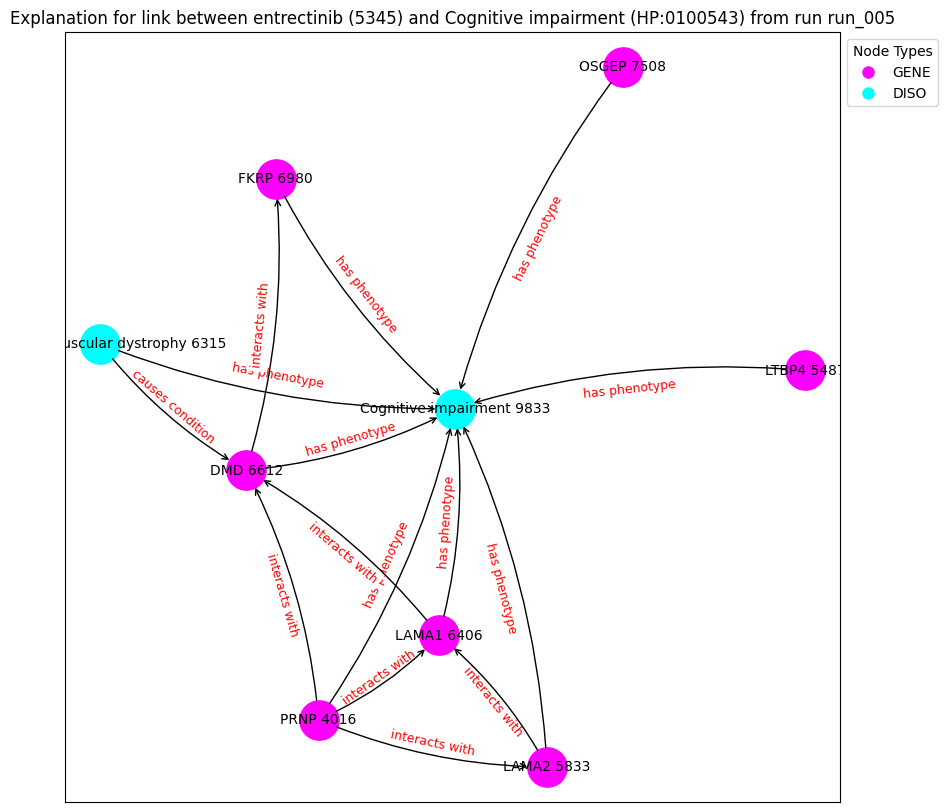

('PRNP 4016', {'type': 'GENE'})
('LTBP4 5487', {'type': 'GENE'})
('LAMA2 5833', {'type': 'GENE'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('LAMA1 6406', {'type': 'GENE'})
('DMD 6612', {'type': 'GENE'})
('FKRP 6980', {'type': 'GENE'})
('OSGEP 7508', {'type': 'GENE'})
('Cognitive impairment 9833', {'type': 'DISO'})
('PRNP 4016', 'DMD 6612', {'label': 'interacts with'})
('PRNP 4016', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('PRNP 4016', 'LAMA1 6406', {'label': 'interacts with'})
('PRNP 4016', 'LAMA2 5833', {'label': 'interacts with'})
('LTBP4 5487', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('LAMA2 5833', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('LAMA2 5833', 'LAMA1 6406', {'label': 'interacts with'})
('Duchenne muscular dystrophy 6315', 'DMD 6612', {'label': 'causes condition'})
('Duchenne muscular dystrophy 6315', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('LAMA1 6406', 'DMD 6612', {'label': 'interacts with'}

Explain edge between nodes 2517 and 86:  54%|█████▍    | 379/700 [4:37:23<3:54:56, 43.91s/it]


KeyboardInterrupt: 

In [58]:
def get_node_idx(id, nodes): 
    return nodes[nodes['id'] == id].index.values.astype(int)[0]

def is_overlapping_pair(symptom_id, drug_id):
    if symptom_id in overlapping_symptoms_drugs:
        if drug_id in overlapping_symptoms_drugs[symptom_id]:
            return True
    return False

found_explations_list = []

for run_dir in run_folders_paths:
    print(run_dir)
    run_name = run_dir.split('\\')[-1]
    
    symptoms_drugs = pd.read_pickle(f'{run_dir}/pred/candidates_per_symptom_{dataset_nr}_{embedding_method}.pkl')   
    
    if embedding_method == 'e2v':
        embedding = loadEdge2VecEmbedding(current_run_dir=run_dir)
    else:
        embedding = loadMetapath2VecEmbedding(current_run_dir=run_dir)
        
    G = create_graph(embedding=embedding)
    edge_labels_dict = dict([((n1, n2), G.edges[(n1,n2)]['edge_label']) for n1, n2 in G.edges])
    
    best_model = load_trained_model(current_run_dir=run_dir, embedding=embedding)
    
    x = torch.Tensor(embedding['Embedding'])
    edge_index = torch.Tensor(np.array(G.edges).transpose()).type(torch.int64).long()
    
    complete_explanation_nr = 0
    incomplete_explanation_nr = 0
    
    for ind, edge in symptoms_drugs.iterrows(): 
        symptom_id = edge['Symptom']
        for drug_id in edge['Candidates']:
            if is_overlapping_pair(symptom_id=symptom_id, drug_id=drug_id):
            
                node_idx1 = get_node_idx(symptom_id, nodes)
                print('node1:')
                print(nodes.loc[[node_idx1]])

                node_idx2 = get_node_idx(str(drug_id), nodes)
                print('node2:')
                print(nodes.loc[[node_idx2]])
                
                found_edge_mask, found_limit, is_complete = explain_edge(node_idx1=node_idx1, node_idx2=node_idx2,
                                                                         model=best_model, x=x, edge_index=edge_index, G=G)
                
                if found_edge_mask is not None and found_limit is not None:
                    if is_complete:
                        complete_explanation_nr += 1
                        explanation_nr = complete_explanation_nr
                    else:
                        incomplete_explanation_nr += 1
                        explanation_nr = incomplete_explanation_nr
                    
                    found_explanation= {'symptom': symptom_id, 'drug': drug_id, 
                                        'node_idx1': node_idx1, 'node_idx2': node_idx2, 
                                        'found_edge_mask': found_edge_mask, 'found_limit': found_limit, 
                                        'complete': is_complete, 'run': run_name}
                    
                    found_explations_list.append(found_explanation)
                    
                    
                    visualize_explanation(explanation_nr, found_explanation, edge_index, edge_labels_dict)
        
    with open(f'{expl_output_dir}/{run_name}_explanations.txt', 'w') as f:
        f.write(f'Total of {complete_explanation_nr} complete explanations found and total of {incomplete_explanation_nr} incomplete explanations found for run {run_name}')

In [ ]:
found_explations_list

[{'symptom': 'HP:0001290',
  'drug': '269',
  'node_idx1': 5372,
  'node_idx2': 4998,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.9938),
  'complete': False,
  'run': 'run_001'},
 {'symptom': 'HP:0001638',
  'drug': '1576',
  'node_idx1': 3222,
  'node_idx2': 5262,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.9937),
  'complete': True,
  'run': 'run_001'},
 {'symptom': 'HP:0011675',
  'drug': '1576',
  'node_idx1': 4336,
  'node_idx2': 5262,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.0063),
  'complete': True,
  'run': 'run_001'},
 {'symptom': 'HP:0001290',
  'drug': '269',
  'node_idx1': 5372,
  'node_idx2': 4998,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.9938),
  'complete': False,
  'run': 'run_002'},
 {'symptom': 'HP:0001638',
  'drug': '1576',
  'node_idx1': 3222,
  'node_idx2': 5262,
  'found_edge_mask': tens